In [1]:
import sys

sys.path.insert(
    1, "..\\utilities\\"
)  # adds utilities folder to path so we can import modules from it, won't be needed after packaging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import loading_utils as load

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]

In [2]:
data_dir = "./results/new/resampled/"
trial_stats_dict = {}
stim_stats_dict = {}
for participant_id in participant_list:
    data_path = os.path.join(data_dir, str(participant_id) + "_nonan_50_resampled_data.csv")
    data_df_new = pd.read_csv(data_path)

    groupby_df = (
        data_df_new[
            ["Block", "Trial no", "Trial type", "Trial phase", "Stim eye - Size Mm"]
        ]
        .groupby(["Block", "Trial no", "Trial type"])
        .agg(["count", "size"])
        .reset_index()
    )
    groupby_df[("Stim eye - Size Mm", "count/size ratio")] = (
        groupby_df[("Stim eye - Size Mm", "count")]
        / groupby_df[("Stim eye - Size Mm", "size")]
    )
    groupby_df[("Stim eye - Size Mm", "more than 50%")] = (
        groupby_df[("Stim eye - Size Mm", "count/size ratio")] >= 0.5
    )
    trial_stats_dict[str(participant_id)] = (
        groupby_df[
            [
                ("Block", ""),
                ("Trial no", ""),
                ("Trial type", ""),
                ("Stim eye - Size Mm", "count/size ratio"),
                ("Stim eye - Size Mm", "more than 50%"),
            ]
        ]
        .groupby([("Block", ""), ("Trial type", "")])
        .agg(
            {
                ("Stim eye - Size Mm", "count/size ratio"): [
                    "mean",
                    "std",
                    "min",
                    "max",
                ],
                ("Stim eye - Size Mm", "more than 50%"): "sum",
                ("Trial no", ""): "count",
            }
        )
        .reset_index()
    )
    
    #now for only stimulus phase
    
    data_df_new = data_df_new[data_df_new['Trial phase']=='stim']
    groupby_df = (
        data_df_new[
            ["Block", "Trial no", "Trial type", "Stim eye - Size Mm"]
        ]
        .groupby(["Block", "Trial no", "Trial type"])
        .agg(["count", "size"])
        .reset_index()
    )
    groupby_df[("Stim eye - Size Mm", "count/size ratio")] = (
        groupby_df[("Stim eye - Size Mm", "count")]
        / groupby_df[("Stim eye - Size Mm", "size")]
    )
    groupby_df[("Stim eye - Size Mm", "more than 50%")] = (
        groupby_df[("Stim eye - Size Mm", "count/size ratio")] >= 0.5
    )
    stim_stats_dict[str(participant_id)] = (
        groupby_df[
            [
                ("Block", ""),
                ("Trial no", ""),
                ("Trial type", ""),
                ("Stim eye - Size Mm", "count/size ratio"),
                ("Stim eye - Size Mm", "more than 50%"),
            ]
        ]
        .groupby([("Block", ""), ("Trial type", "")])
        .agg(
            {
                ("Stim eye - Size Mm", "count/size ratio"): [
                    "mean",
                    "std",
                    "min",
                    "max",
                ],
                ("Stim eye - Size Mm", "more than 50%"): "sum",
                ("Trial no", ""): "count",
            }
        )
        .reset_index()
    )
    data_df_new = []
    groupby_df = []

## Summary:

I did statistics per block, per condition for three types of datasets:

1. All NaNs removed, resampled to 50 Hz
2. NaNs resulting from non-stimulated eye measurement removed, resampled to 50 Hz.
3. NaNs resulting from non-stimulated eye measurement removed, resampled to 25 Hz.

There isn't a visible difference between 1 and 2, which was to be expected, since resampling I coded uses mean without NaNs and doesn't fill them.
Here I list blocks per participant that have data completeness issues with short commentary based on statistics for 50 Hz resampled data:

Participant 200: over 50% data remaining in almost all trials with at most 1-2 exceptions per block.

Participant 201: block 0: only 5 trials per condition. (need to double check if nothing went wrong with pulling data), block 5: about 5/10 trials at more than 50% per cond.

Participant 202: block 2: about 5/10 trials at more than 50% per cond., block 10: about 13-15 trials out of 20  at more than 50% per cond.

Participant 204: blocks 0, 5, 6, 7, 8, 9: almost no trials at more than 50% available data per cond.

Participant 205: sparse data, almost all of it is at much below 50% data available.

Participant 206: block 1: almost no data at >50%. Most blocks have more than 5 trials per condition at more than 50% data available.

Participant 207: blocks 2,3,4,5,6,10: close to 0 trials with more than 50% data.

Participant 209: only block 5 has fairly complete trials (more than 50% data).

Participant 210: most blocks have few or zero trials with more than 50% data available.

Participant 211: blocks 5, 6, 7: about half the trials with more than 50% data per cond.

Participant 212: blocks 0, 1, 6: about half the trials with more than 50% data per cond.

Participant 213: blocks 0,5,6,7,8: close to 0 trials with more than 50% data remaining, blocks 9,10: about half of trials.

Global conclusion: if data is missing, it's usually missing in the whole block to a similar level. Participants 204, 205, 207, 209, 210, 213 have the most missing data. 

Analysis in current state should be possible without larger issues for 200, 201, 202, 211, 212, especially if data were to be downsampled more (e.g. to 25 - 30 Hz). For 206, block 1 may need to be excluded.


## Statistics of available data for each participant per block, per stimulus

count/size ratio - number of samples without nan measurements divided by number of all samples

The above is calculated for each trial, grouped by trial type and trial phase. Then the mean, standard deviation, minimum and maximum are calculated for each group.

more than 50% - count - number of trials with count/size ratio higher or equal to 0.5

Trial no - count - overall number of trials

### Participant 200

In [3]:
print('Statistics for whole trials')
trial_stats_dict["200"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.585804  0.001818  0.582545  0.587802   
1      0        l-m           0.586330  0.001995  0.581493  0.587802   
2      0        lms           0.587066  0.001571  0.583596  0.588854   
3      0        mel           0.585594  0.002400  0.581493  0.588854   
4      0          s           0.586751  0.001311  0.583596  0.588854   
5      1       flux           0.585279  0.003104  0.577287  0.587802   
6      1        l-m           0.586225  0.001136  0.583596  0.587802   
7      1        lms           0.586751  0.001644  0.582545  0.588854   
8      1        mel           0.586856  0.001157  0.584648  0.587802   
9      1          s           0.585594  0.001602  0.582545  0.587802   
10     2       flux           0.584543  0.002400  0.579390  0.586751   
11     2        l-m           0.585279  0.003649  0.576236  0.588854   
12     2        lms           0.585804  0.001441  0.582545  0.587802   
13     2        mel           0.584017  0.004682  0.573081  0.587802   
14     2          s           0.584122  0.005436  0.572029  0.587802   
15     3       flux           0.587277  0.001136  0.584648  0.588854   
16     3        l-m           0.586751  0.002217  0.582545  0.588854   
17     3        lms           0.587487  0.001114  0.585699  0.588854   
18     3        mel           0.587066  0.001114  0.584648  0.588854   
19     3          s           0.586540  0.001194  0.584648  0.587802   
20     4       flux           0.586540  0.001384  0.583596  0.587802   
21     4        l-m           0.585699  0.002576  0.581493  0.588854   
22     4        lms           0.586961  0.001086  0.584648  0.587802   
23     4        mel           0.586330  0.001583  0.583596  0.587802   
24     4          s           0.585174  0.003371  0.576236  0.587802   
25     5       flux           0.583596  0.003840  0.577287  0.587802   
26     5        l-m           0.582650  0.007476  0.562566  0.587802   
27     5        lms           0.584332  0.003098  0.577287  0.586751   
28     5        mel           0.584543  0.003415  0.578339  0.587802   
29     5          s           0.582440  0.004501  0.574132  0.586751   
30     6       flux           0.586120  0.002632  0.582545  0.588854   
31     6        l-m           0.581703  0.005647  0.569926  0.587802   
32     6        lms           0.584017  0.005366  0.569926  0.588854   
33     6        mel           0.585910  0.002314  0.580442  0.588854   
34     6          s           0.573081  0.038361  0.464774  0.588854   
35     7       flux           0.587277  0.000894  0.585699  0.588854   
36     7        l-m           0.586751  0.001108  0.584648  0.587802   
37     7        lms           0.587277  0.000894  0.585699  0.588854   
38     7        mel           0.586646  0.001259  0.583596  0.587802   
39     7          s           0.586330  0.001419  0.583596  0.587802   
40     8       flux           0.584648  0.003894  0.572029  0.587802   
41     8        l-m           0.586891  0.001426  0.584648  0.588854   
42     8        lms           0.570369  0.060287  0.352584  0.588854   
43     8        mel           0.585769  0.002083  0.579390  0.587802   
44     8          s           0.585209  0.002662  0.580442  0.588854   
45     9       flux           0.580652  0.009151  0.563617  0.587802   
46     9        l-m           0.580757  0.007336  0.567823  0.587802   
47     9        lms           0.580126  0.011107  0.555205  0.588854   
48     9        mel           0.583491  0.004993  0.572029  0.586751   
49     9          s           0.581598  0.008390  0.566772  0.588854   
50    10       flux           0.586225  0.002390  0.580442  0.588854   
51    10        l-m           0.587697  0.000921  0.585699  0.588854   
52    10        lms           0.584858  0.0

In [4]:
print('Statistics for stimulus phase')
stim_stats_dict["200"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.588048  0.002057  0.585657  0.589641   
1      0        l-m           0.586853  0.002689  0.581673  0.589641   
2      0        lms           0.586454  0.003143  0.581673  0.589641   
3      0        mel           0.587649  0.003872  0.577689  0.589641   
4      0          s           0.586056  0.003488  0.581673  0.589641   
5      1       flux           0.583267  0.012055  0.549801  0.589641   
6      1        l-m           0.586853  0.002689  0.581673  0.589641   
7      1        lms           0.588446  0.002689  0.585657  0.593625   
8      1        mel           0.587251  0.002786  0.581673  0.589641   
9      1          s           0.584064  0.005039  0.573705  0.589641   
10     2       flux           0.584462  0.010123  0.557769  0.593625   
11     2        l-m           0.587251  0.002057  0.585657  0.589641   
12     2        lms           0.583665  0.004695  0.577689  0.589641   
13     2        mel           0.584861  0.007225  0.565737  0.589641   
14     2          s           0.585259  0.004770  0.573705  0.589641   
15     3       flux           0.588845  0.001680  0.585657  0.589641   
16     3        l-m           0.586056  0.004384  0.577689  0.589641   
17     3        lms           0.588048  0.002786  0.581673  0.589641   
18     3        mel           0.588446  0.001924  0.585657  0.589641   
19     3          s           0.587251  0.003360  0.581673  0.589641   
20     4       flux           0.586056  0.004770  0.577689  0.589641   
21     4        l-m           0.586056  0.003488  0.577689  0.589641   
22     4        lms           0.588446  0.002689  0.585657  0.593625   
23     4        mel           0.586056  0.003962  0.577689  0.589641   
24     4          s           0.582869  0.007979  0.561753  0.589641   
25     5       flux           0.585259  0.004770  0.577689  0.589641   
26     5        l-m           0.583267  0.008441  0.561753  0.589641   
27     5        lms           0.584462  0.008617  0.561753  0.589641   
28     5        mel           0.588845  0.001680  0.585657  0.589641   
29     5          s           0.583267  0.005697  0.573705  0.589641   
30     6       flux           0.588845  0.001680  0.585657  0.589641   
31     6        l-m           0.582470  0.011699  0.561753  0.593625   
32     6        lms           0.586853  0.004221  0.577689  0.589641   
33     6        mel           0.585657  0.005634  0.573705  0.589641   
34     6          s           0.552590  0.111602  0.235060  0.589641   
35     7       flux           0.587251  0.002786  0.581673  0.589641   
36     7        l-m           0.584861  0.002520  0.581673  0.589641   
37     7        lms           0.587649  0.003872  0.581673  0.593625   
38     7        mel           0.587251  0.003360  0.581673  0.589641   
39     7          s           0.585259  0.004770  0.573705  0.589641   
40     8       flux           0.585923  0.003829  0.577689  0.589641   
41     8        l-m           0.585923  0.004115  0.577689  0.589641   
42     8        lms           0.567331  0.074334  0.298805  0.589641   
43     8        mel           0.586189  0.003647  0.577689  0.589641   
44     8          s           0.586189  0.004224  0.577689  0.589641   
45     9       flux           0.579681  0.010157  0.561753  0.589641   
46     9        l-m           0.580478  0.009947  0.565737  0.589641   
47     9        lms           0.570916  0.027923  0.498008  0.589641   
48     9        mel           0.584064  0.009795  0.557769  0.589641   
49     9          s           0.578884  0.012323  0.557769  0.589641   
50    10       flux           0.584861  0.005245  0.573705  0.589641   
51    10        l-m           0.588048  0.002057  0.585657  0.589641   
52    10        lms           0.584064  0.0

### Participant 201

In [5]:
print('Statistics for whole trials')
trial_stats_dict["201"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.549829  0.036522  0.502629  0.586751   
1      0        l-m           0.525342  0.096327  0.354364  0.586751   
2      0        lms           0.539559  0.057054  0.458333  0.586466   
3      0        mel           0.494695  0.090931  0.345952  0.572029   
4      0          s           0.548522  0.061741  0.440589  0.587542   
5      1       flux           0.570662  0.015375  0.537329  0.586751   
6      1        l-m           0.573396  0.008868  0.557308  0.584648   
7      1        lms           0.569926  0.016648  0.542587  0.584648   
8      1        mel           0.568665  0.014219  0.532072  0.582545   
9      1          s           0.563353  0.016641  0.542587  0.585699   
10     2       flux           0.577392  0.011704  0.546793  0.587802   
11     2        l-m           0.580442  0.007615  0.562566  0.586751   
12     2        lms           0.576236  0.014090  0.548896  0.587802   
13     2        mel           0.574658  0.010483  0.548896  0.585699   
14     2          s           0.579916  0.006506  0.565720  0.587802   
15     3       flux           0.571924  0.010579  0.555205  0.587802   
16     3        l-m           0.568980  0.019008  0.543638  0.588854   
17     3        lms           0.569401  0.013136  0.552050  0.586751   
18     3        mel           0.576025  0.014686  0.550999  0.587802   
19     3          s           0.576130  0.015866  0.533123  0.587802   
20     4       flux           0.531966  0.070115  0.366982  0.587802   
21     4        l-m           0.563091  0.030985  0.502629  0.587802   
22     4        lms           0.546011  0.061062  0.391304  0.588854   
23     4        mel           0.557465  0.036458  0.468447  0.588854   
24     4          s           0.554259  0.041421  0.464774  0.586751   
25     5       flux           0.491917  0.082562  0.317256  0.579390   
26     5        l-m           0.479730  0.077261  0.350242  0.566772   
27     5        lms           0.482621  0.105982  0.225026  0.582545   
28     5        mel           0.463565  0.097131  0.270242  0.587802   
29     5          s           0.482309  0.097660  0.296530  0.582545   
30     6       flux           0.577392  0.006696  0.563617  0.583596   
31     6        l-m           0.568349  0.017639  0.536278  0.586751   
32     6        lms           0.572976  0.016376  0.538381  0.586751   
33     6        mel           0.576236  0.011293  0.552050  0.584648   
34     6          s           0.564143  0.015062  0.537329  0.580442   
35     7       flux           0.568875  0.023450  0.526814  0.587802   
36     7        l-m           0.564669  0.042664  0.447950  0.587802   
37     7        lms           0.544795  0.063972  0.405889  0.586751   
38     7        mel           0.548580  0.061262  0.414301  0.586751   
39     7          s           0.529338  0.093330  0.324921  0.588854   
40     8       flux           0.585804  0.001353  0.583596  0.587802   
41     8        l-m           0.582334  0.011015  0.552050  0.588854   
42     8        lms           0.583491  0.004714  0.575184  0.587802   
43     8        mel           0.584227  0.007118  0.564669  0.589905   
44     8          s           0.579916  0.011764  0.558360  0.589905   
45     9       flux           0.580336  0.011449  0.557308  0.587802   
46     9        l-m           0.586120  0.002941  0.578339  0.588854   
47     9        lms           0.585068  0.002228  0.581493  0.587802   
48     9        mel           0.583176  0.007650  0.567823  0.588854   
49     9          s           0.584963  0.005129  0.570978  0.587802   
50    10       flux           0.577813  0.010282  0.553102  0.587802   
51    10        l-m           0.579916  0.007340  0.562566  0.587802   
52    10        lms           0.572555  0.0

In [6]:
print('Statistics for stimulus phase')
stim_stats_dict["201"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.560159  0.061502  0.450199  0.589641   
1      0        l-m           0.564143  0.054815  0.466135  0.589641   
2      0        lms           0.546614  0.060513  0.442231  0.589641   
3      0        mel           0.415139  0.240226  0.003984  0.589641   
4      0          s           0.562550  0.060644  0.454183  0.593625   
5      1       flux           0.577291  0.026789  0.501992  0.589641   
6      1        l-m           0.579681  0.010499  0.561753  0.593625   
7      1        lms           0.581275  0.009659  0.561753  0.589641   
8      1        mel           0.580876  0.007225  0.565737  0.589641   
9      1          s           0.580478  0.008197  0.561753  0.589641   
10     2       flux           0.584462  0.004620  0.573705  0.589641   
11     2        l-m           0.586454  0.003143  0.581673  0.589641   
12     2        lms           0.588048  0.002786  0.581673  0.589641   
13     2        mel           0.586056  0.004770  0.577689  0.593625   
14     2          s           0.586454  0.006452  0.569721  0.593625   
15     3       flux           0.586056  0.003962  0.577689  0.589641   
16     3        l-m           0.584861  0.011547  0.553785  0.589641   
17     3        lms           0.585259  0.007382  0.565737  0.593625   
18     3        mel           0.588446  0.001924  0.585657  0.589641   
19     3          s           0.586853  0.004987  0.573705  0.589641   
20     4       flux           0.584462  0.009017  0.561753  0.593625   
21     4        l-m           0.584064  0.013569  0.545817  0.589641   
22     4        lms           0.568924  0.045340  0.442231  0.589641   
23     4        mel           0.587251  0.002786  0.581673  0.589641   
24     4          s           0.568526  0.036662  0.478088  0.589641   
25     5       flux           0.533466  0.063452  0.442231  0.585657   
26     5        l-m           0.504382  0.117246  0.306773  0.593625   
27     5        lms           0.531474  0.078639  0.370518  0.589641   
28     5        mel           0.491235  0.113638  0.286853  0.589641   
29     5          s           0.543028  0.076544  0.410359  0.593625   
30     6       flux           0.587649  0.002817  0.581673  0.589641   
31     6        l-m           0.586853  0.003280  0.581673  0.589641   
32     6        lms           0.586454  0.003661  0.581673  0.589641   
33     6        mel           0.588845  0.002520  0.585657  0.593625   
34     6          s           0.588446  0.002689  0.585657  0.593625   
35     7       flux           0.566534  0.044317  0.450199  0.589641   
36     7        l-m           0.586853  0.002689  0.581673  0.589641   
37     7        lms           0.523904  0.124682  0.266932  0.589641   
38     7        mel           0.521514  0.139049  0.215139  0.589641   
39     7          s           0.494821  0.182416  0.147410  0.589641   
40     8       flux           0.586853  0.004221  0.581673  0.593625   
41     8        l-m           0.586056  0.005126  0.573705  0.589641   
42     8        lms           0.586454  0.002520  0.581673  0.589641   
43     8        mel           0.587649  0.004303  0.577689  0.593625   
44     8          s           0.586853  0.003780  0.577689  0.589641   
45     9       flux           0.586454  0.002520  0.581673  0.589641   
46     9        l-m           0.588048  0.002786  0.581673  0.589641   
47     9        lms           0.586056  0.003488  0.581673  0.589641   
48     9        mel           0.586454  0.004115  0.581673  0.593625   
49     9          s           0.587649  0.003386  0.581673  0.589641   
50    10       flux           0.585657  0.005634  0.577689  0.589641   
51    10        l-m           0.585259  0.008067  0.565737  0.589641   
52    10        lms           0.582072  0.0

### Participant 202

In [7]:
print('Statistics for whole trials')
trial_stats_dict["202"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.573502  0.022019  0.524711  0.588854   
1      0        l-m           0.584122  0.003751  0.577287  0.587802   
2      0        lms           0.581283  0.013753  0.544690  0.587802   
3      0        mel           0.577497  0.018493  0.529968  0.588854   
4      0          s           0.581598  0.005875  0.570978  0.588854   
5      1       flux           0.569190  0.031213  0.497371  0.588854   
6      1        l-m           0.562145  0.039476  0.472135  0.587802   
7      1        lms           0.571399  0.041745  0.455310  0.588854   
8      1        mel           0.563512  0.074605  0.351209  0.588854   
9      1          s           0.566772  0.051407  0.421661  0.588854   
10     2       flux           0.551104  0.062519  0.382755  0.588854   
11     2        l-m           0.538275  0.085832  0.360673  0.587802   
12     2        lms           0.514826  0.100570  0.282860  0.587802   
13     2        mel           0.565195  0.039154  0.458465  0.588854   
14     2          s           0.542797  0.092157  0.307045  0.587802   
15     3       flux           0.578233  0.008776  0.564669  0.587802   
16     3        l-m           0.584332  0.007201  0.564669  0.588854   
17     3        lms           0.578023  0.010528  0.559411  0.586751   
18     3        mel           0.582229  0.006725  0.569926  0.587802   
19     3          s           0.583701  0.003790  0.576236  0.587802   
20     4       flux           0.575605  0.013358  0.550999  0.587802   
21     4        l-m           0.583807  0.002614  0.579390  0.586751   
22     4        lms           0.573081  0.022029  0.517350  0.586751   
23     4        mel           0.575815  0.019435  0.529968  0.587802   
24     4          s           0.572029  0.021669  0.528917  0.587802   
25     5       flux           0.543007  0.062391  0.436383  0.587802   
26     5        l-m           0.542797  0.068202  0.390116  0.588854   
27     5        lms           0.557834  0.036541  0.496320  0.587802   
28     5        mel           0.565468  0.024387  0.524711  0.587802   
29     5          s           0.550999  0.042624  0.460568  0.588854   
30     6       flux           0.557098  0.055193  0.416404  0.586751   
31     6        l-m           0.539748  0.087830  0.331230  0.587802   
32     6        lms           0.566667  0.035993  0.480547  0.587802   
33     6        mel           0.581914  0.008342  0.566772  0.587802   
34     6          s           0.560988  0.033624  0.503680  0.586751   
35     7       flux           0.584122  0.009303  0.558360  0.588854   
36     7        l-m           0.567823  0.035552  0.496320  0.588854   
37     7        lms           0.585804  0.003305  0.579390  0.588854   
38     7        mel           0.586540  0.002091  0.581493  0.588854   
39     7          s           0.585910  0.002966  0.579390  0.588854   
40     8       flux           0.578339  0.011636  0.552050  0.588854   
41     8        l-m           0.582860  0.010917  0.553102  0.588854   
42     8        lms           0.575394  0.018124  0.535226  0.587802   
43     8        mel           0.578759  0.016723  0.537329  0.588854   
44     8          s           0.579180  0.013253  0.546793  0.588854   
45     9       flux           0.586751  0.001214  0.584648  0.588854   
46     9        l-m           0.586961  0.001907  0.582545  0.588854   
47     9        lms           0.587487  0.001219  0.584648  0.588854   
48     9        mel           0.587171  0.001504  0.584648  0.588854   
49     9          s           0.584437  0.008468  0.560463  0.587802   
50    10       flux           0.467657  0.165177  0.053152  0.587802   
51    10        l-m           0.429109  0.189659  0.055782  0.587802   
52    10        lms           0.475788  0.1

In [8]:
print('Statistics for stimulus phase')
stim_stats_dict["202"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.584064  0.005998  0.569721  0.589641   
1      0        l-m           0.588845  0.003143  0.581673  0.593625   
2      0        lms           0.587251  0.003849  0.577689  0.589641   
3      0        mel           0.572908  0.044674  0.446215  0.589641   
4      0          s           0.583665  0.008023  0.565737  0.589641   
5      1       flux           0.564542  0.048688  0.442231  0.593625   
6      1        l-m           0.545418  0.076137  0.358566  0.589641   
7      1        lms           0.569323  0.054609  0.414343  0.589641   
8      1        mel           0.547410  0.125190  0.191235  0.589641   
9      1          s           0.539044  0.130512  0.171315  0.589641   
10     2       flux           0.529482  0.121010  0.195219  0.589641   
11     2        l-m           0.558167  0.068864  0.366534  0.589641   
12     2        lms           0.482072  0.175419  0.091633  0.593625   
13     2        mel           0.562151  0.054802  0.418327  0.589641   
14     2          s           0.545020  0.097622  0.290837  0.589641   
15     3       flux           0.572908  0.020981  0.537849  0.589641   
16     3        l-m           0.582869  0.018786  0.529880  0.593625   
17     3        lms           0.559761  0.041072  0.482072  0.589641   
18     3        mel           0.577689  0.019061  0.533865  0.589641   
19     3          s           0.582470  0.008769  0.561753  0.589641   
20     4       flux           0.574900  0.019065  0.533865  0.589641   
21     4        l-m           0.585259  0.006627  0.569721  0.589641   
22     4        lms           0.584462  0.008617  0.561753  0.589641   
23     4        mel           0.581673  0.018402  0.529880  0.589641   
24     4          s           0.568526  0.036469  0.482072  0.593625   
25     5       flux           0.535458  0.084623  0.326693  0.593625   
26     5        l-m           0.561753  0.057336  0.406375  0.589641   
27     5        lms           0.565737  0.030458  0.509960  0.589641   
28     5        mel           0.556175  0.045897  0.454183  0.589641   
29     5          s           0.558566  0.050072  0.458167  0.593625   
30     6       flux           0.555777  0.077578  0.338645  0.589641   
31     6        l-m           0.575697  0.025215  0.505976  0.589641   
32     6        lms           0.582869  0.007979  0.561753  0.589641   
33     6        mel           0.587649  0.002817  0.581673  0.589641   
34     6          s           0.582470  0.006719  0.569721  0.589641   
35     7       flux           0.586454  0.006452  0.569721  0.589641   
36     7        l-m           0.549004  0.066608  0.394422  0.589641   
37     7        lms           0.586853  0.004987  0.577689  0.593625   
38     7        mel           0.587649  0.006573  0.569721  0.593625   
39     7          s           0.587251  0.003360  0.581673  0.589641   
40     8       flux           0.574104  0.019468  0.537849  0.589641   
41     8        l-m           0.577689  0.024415  0.517928  0.593625   
42     8        lms           0.577689  0.017916  0.537849  0.593625   
43     8        mel           0.583267  0.009795  0.561753  0.589641   
44     8          s           0.581673  0.014788  0.553785  0.589641   
45     9       flux           0.586853  0.002689  0.581673  0.589641   
46     9        l-m           0.586454  0.003143  0.581673  0.589641   
47     9        lms           0.587649  0.004303  0.577689  0.589641   
48     9        mel           0.586853  0.003780  0.581673  0.589641   
49     9          s           0.584462  0.009586  0.557769  0.589641   
50    10       flux           0.477511  0.183315  0.000000  0.589641   
51    10        l-m           0.438247  0.199748  0.000000  0.589641   
52    10        lms           0.483869  0.1

### Participant 204

In [9]:
print('Statistics for whole trials')
trial_stats_dict["204"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.339694  0.116721  0.178759  0.513144   
1      0        l-m           0.352349  0.117677  0.126486  0.519453   
2      0        lms           0.387028  0.091810  0.242902  0.534175   
3      0        mel           0.384285  0.087803  0.242038  0.505783   
4      0          s           0.355047  0.152163  0.171399  0.558360   
5      1       flux           0.519410  0.049381  0.432177  0.576236   
6      1        l-m           0.483756  0.095372  0.251314  0.569926   
7      1        lms           0.453373  0.126343  0.213542  0.578339   
8      1        mel           0.460700  0.129725  0.241176  0.584648   
9      1          s           0.492311  0.083825  0.349106  0.579390   
10     2       flux           0.518247  0.070468  0.364879  0.577287   
11     2        l-m           0.537960  0.031683  0.492114  0.584648   
12     2        lms           0.507366  0.106762  0.272345  0.583596   
13     2        mel           0.453175  0.110596  0.282860  0.577287   
14     2          s           0.518717  0.065381  0.353312  0.577287   
15     3       flux           0.477872  0.092306  0.287066  0.570978   
16     3        l-m           0.487674  0.044211  0.392219  0.555205   
17     3        lms           0.473807  0.064132  0.342797  0.564568   
18     3        mel           0.505994  0.043227  0.402734  0.570978   
19     3          s           0.491796  0.041366  0.423747  0.547844   
20     4       flux           0.450266  0.086896  0.323870  0.539432   
21     4        l-m           0.422431  0.099362  0.280757  0.547844   
22     4        lms           0.441790  0.145657  0.056782  0.541535   
23     4        mel           0.463731  0.077636  0.343552  0.566772   
24     4          s           0.473834  0.056131  0.369085  0.559411   
25     5       flux           0.406220  0.082351  0.287066  0.559411   
26     5        l-m           0.423611  0.095410  0.209451  0.523659   
27     5        lms           0.358056  0.122205  0.129338  0.506835   
28     5        mel           0.423449  0.040423  0.374343  0.483701   
29     5          s           0.428391  0.107189  0.158780  0.514196   
30     6       flux           0.386028  0.133869  0.177708  0.545741   
31     6        l-m           0.415679  0.103211  0.271293  0.573081   
32     6        lms           0.336463  0.126789  0.093369  0.463722   
33     6        mel           0.434175  0.128613  0.158780  0.565720   
34     6          s           0.386017  0.125165  0.118159  0.508938   
35     7       flux           0.304384  0.109405  0.140052  0.540484   
36     7        l-m           0.284120  0.132157  0.038462  0.483701   
37     7        lms           0.336740  0.175190  0.019608  0.555205   
38     7        mel           0.322356  0.144024  0.065073  0.528917   
39     7          s           0.303540  0.144802  0.096257  0.518402   
40     8       flux           0.391257  0.124028  0.187171  0.560463   
41     8        l-m           0.433798  0.065814  0.325330  0.537329   
42     8        lms           0.415447  0.091904  0.256466  0.559411   
43     8        mel           0.408502  0.061423  0.337539  0.493165   
44     8          s           0.460833  0.091349  0.281809  0.563617   
45     9       flux           0.415317  0.139636  0.058885  0.555205   
46     9        l-m           0.401796  0.101378  0.216614  0.523659   
47     9        lms           0.376523  0.149869  0.023134  0.502629   
48     9        mel           0.403542  0.081120  0.258344  0.511041   
49     9          s           0.367182  0.160321  0.031546  0.545741   
50    10       flux           0.539432  0.021135  0.491062  0.566772   
51    10        l-m           0.529968  0.014511  0.504732  0.553102   
52    10        lms           0.532492  0.0

In [10]:
print('Statistics for stimulus phase')
stim_stats_dict["204"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.305976  0.205863  0.003984  0.577689   
1      0        l-m           0.344622  0.179870  0.031873  0.549801   
2      0        lms           0.448606  0.109418  0.254980  0.585657   
3      0        mel           0.392032  0.109676  0.262948  0.577689   
4      0          s           0.354183  0.192233  0.123506  0.565737   
5      1       flux           0.525896  0.055745  0.410359  0.589641   
6      1        l-m           0.501195  0.082675  0.366534  0.589641   
7      1        lms           0.475299  0.088591  0.270916  0.569721   
8      1        mel           0.509562  0.086198  0.354582  0.589641   
9      1          s           0.490837  0.154060  0.191235  0.589641   
10     2       flux           0.488845  0.174957  0.000000  0.573705   
11     2        l-m           0.543028  0.058374  0.426295  0.593625   
12     2        lms           0.492430  0.099401  0.310757  0.585657   
13     2        mel           0.378486  0.215884  0.000000  0.589641   
14     2          s           0.506773  0.078517  0.342629  0.585657   
15     3       flux           0.498008  0.070322  0.382470  0.589641   
16     3        l-m           0.501195  0.058487  0.398406  0.569721   
17     3        lms           0.545817  0.029035  0.498008  0.577689   
18     3        mel           0.520717  0.062517  0.374502  0.569721   
19     3          s           0.541036  0.054069  0.422311  0.589641   
20     4       flux           0.478088  0.068647  0.334661  0.577689   
21     4        l-m           0.469323  0.121189  0.294821  0.589641   
22     4        lms           0.445817  0.183281  0.000000  0.573705   
23     4        mel           0.480080  0.086622  0.274900  0.569721   
24     4          s           0.523506  0.047035  0.442231  0.593625   
25     5       flux           0.406375  0.149436  0.079681  0.577689   
26     5        l-m           0.466534  0.082539  0.266932  0.537849   
27     5        lms           0.360159  0.193620  0.000000  0.557769   
28     5        mel           0.376892  0.135030  0.167331  0.545817   
29     5          s           0.477689  0.118640  0.195219  0.573705   
30     6       flux           0.411952  0.123130  0.239044  0.573705   
31     6        l-m           0.506375  0.068427  0.366534  0.585657   
32     6        lms           0.374104  0.163206  0.063745  0.509960   
33     6        mel           0.412351  0.146459  0.147410  0.565737   
34     6          s           0.431474  0.166803  0.075697  0.561753   
35     7       flux           0.251262  0.213789  0.000000  0.569721   
36     7        l-m           0.362019  0.298641  0.000000  1.000000   
37     7        lms           0.391235  0.285129  0.000000  1.000000   
38     7        mel           0.320850  0.238777  0.000000  0.549801   
39     7          s           0.317131  0.238283  0.000000  0.569721   
40     8       flux           0.463347  0.067691  0.346614  0.537849   
41     8        l-m           0.499602  0.074255  0.338645  0.573705   
42     8        lms           0.457769  0.113985  0.223108  0.581673   
43     8        mel           0.392430  0.125963  0.147410  0.517928   
44     8          s           0.528287  0.071669  0.390438  0.589641   
45     9       flux           0.424701  0.165893  0.000000  0.561753   
46     9        l-m           0.408367  0.167048  0.123506  0.589641   
47     9        lms           0.407171  0.162885  0.000000  0.533865   
48     9        mel           0.452988  0.056843  0.386454  0.557769   
49     9          s           0.403187  0.177477  0.000000  0.593625   
50    10       flux           0.553386  0.023790  0.505976  0.589641   
51    10        l-m           0.561753  0.015825  0.541833  0.589641   
52    10        lms           0.531474  0.0

### Participant 205

In [11]:
print('Statistics for whole trials')
trial_stats_dict["205"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.326019  0.117184  0.177479  0.523224   
1      0        l-m           0.266750  0.139377  0.057357  0.506623   
2      0        lms           0.301653  0.153900  0.080745  0.555556   
3      0        mel           0.199245  0.082483  0.086551  0.321767   
4      0          s           0.252209  0.125040  0.099727  0.459459   
5      1       flux           0.366738  0.143857  0.151420  0.526814   
6      1        l-m           0.347849  0.111569  0.144366  0.498423   
7      1        lms           0.328293  0.195361  0.016456  0.547844   
8      1        mel           0.366632  0.118617  0.220612  0.553343   
9      1          s           0.326138  0.131002  0.097792  0.547844   
10     2       flux           0.301354  0.189871  0.085624  0.550999   
11     2        l-m           0.299589  0.133611  0.041009  0.478444   
12     2        lms           0.294495  0.161523  0.075581  0.540484   
13     2        mel           0.261035  0.126414  0.151685  0.509989   
14     2          s           0.310775  0.188527  0.019646  0.552050   
15     3       flux           0.305882  0.100151  0.188223  0.497371   
16     3        l-m           0.270861  0.129124  0.098843  0.533123   
17     3        lms           0.391981  0.079131  0.295478  0.522608   
18     3        mel           0.300558  0.160710  0.055731  0.538381   
19     3          s           0.343003  0.117469  0.118153  0.522608   
20     4       flux           0.152835  0.071356  0.084926  0.285199   
21     4        l-m           0.230064  0.139658  0.027613  0.425868   
22     4        lms           0.200020  0.100743  0.017115  0.347003   
23     4        mel           0.227327  0.119827  0.039604  0.410448   
24     4          s           0.199616  0.101364  0.083714  0.378194   
25     5       flux           0.228038  0.135268  0.026997  0.406940   
26     5        l-m           0.325744  0.131966  0.181818  0.547529   
27     5        lms           0.277573  0.125267  0.044164  0.404837   
28     5        mel           0.313072  0.134014  0.115220  0.500526   
29     5          s           0.292720  0.117300  0.107256  0.491062   
30     6       flux           0.390614  0.100879  0.243954  0.511041   
31     6        l-m           0.401281  0.133051  0.152915  0.555205   
32     6        lms           0.383406  0.148213  0.129338  0.550999   
33     6        mel           0.370309  0.122067  0.158780  0.500526   
34     6          s           0.398915  0.128748  0.125131  0.554154   
35     7       flux           0.432177  0.077663  0.340694  0.513144   
36     7        l-m           0.454679  0.034029  0.421661  0.506835   
37     7        lms           0.458672  0.081408  0.358570  0.560463   
38     7        mel           0.327445  0.123460  0.167192  0.465825   
39     7          s           0.383386  0.064866  0.293375  0.470032   
40     8       flux           0.467823  0.054401  0.364879  0.545741   
41     8        l-m           0.413678  0.074714  0.298109  0.508938   
42     8        lms           0.447617  0.089808  0.280088  0.552050   
43     8        mel           0.348580  0.116739  0.195584  0.546793   
44     8          s           0.391754  0.106669  0.238854  0.544690   
45     9       flux           0.334649  0.105776  0.108954  0.483701   
46     9        l-m           0.333337  0.118957  0.143007  0.467928   
47     9        lms           0.356854  0.137117  0.069401  0.519453   
48     9        mel           0.388033  0.085435  0.256572  0.553102   
49     9          s           0.298390  0.117670  0.116998  0.436383   
50    10       flux           0.350245  0.164156  0.053152  0.547844   
51    10        l-m           0.299543  0.175726  0.055782  0.547844   
52    10        lms           0.379967  0.1

In [12]:
print('Statistics for stimulus phase')
stim_stats_dict["205"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.230279  0.237087  0.000000  0.553785   
1      0        l-m           0.270518  0.231270  0.000000  0.569721   
2      0        lms           0.292987  0.177057  0.115538  0.553785   
3      0        mel           0.177078  0.168269  0.000000  0.462151   
4      0          s           0.268940  0.166240  0.000000  0.494024   
5      1       flux           0.308765  0.204310  0.023904  0.577689   
6      1        l-m           0.385259  0.132004  0.123506  0.565737   
7      1        lms           0.378043  0.232270  0.000000  0.585657   
8      1        mel           0.285525  0.229040  0.000000  0.577689   
9      1          s           0.345817  0.156580  0.083665  0.585657   
10     2       flux           0.337052  0.239819  0.000000  0.593625   
11     2        l-m           0.289066  0.141772  0.000000  0.458167   
12     2        lms           0.346124  0.192872  0.115538  0.628571   
13     2        mel           0.292829  0.137939  0.127490  0.513944   
14     2          s           0.323463  0.223916  0.000000  0.585657   
15     3       flux           0.347012  0.207056  0.000000  0.557769   
16     3        l-m           0.284462  0.204862  0.000000  0.557769   
17     3        lms           0.461355  0.095115  0.298805  0.553785   
18     3        mel           0.319522  0.181825  0.000000  0.549801   
19     3          s           0.361753  0.169121  0.000000  0.581673   
20     4       flux           0.145730  0.181854  0.000000  0.505976   
21     4        l-m           0.185243  0.173588  0.000000  0.462151   
22     4        lms           0.195174  0.139266  0.000000  0.434263   
23     4        mel           0.201541  0.138695  0.000000  0.385321   
24     4          s           0.223035  0.150694  0.031873  0.525896   
25     5       flux           0.255865  0.192597  0.063745  0.541833   
26     5        l-m           0.326479  0.127396  0.175299  0.539906   
27     5        lms           0.257371  0.212784  0.000000  0.509960   
28     5        mel           0.313546  0.168403  0.087649  0.509960   
29     5          s           0.264143  0.193819  0.000000  0.545817   
30     6       flux           0.417928  0.132728  0.167331  0.557769   
31     6        l-m           0.435458  0.163493  0.039841  0.573705   
32     6        lms           0.368526  0.197721  0.000000  0.569721   
33     6        mel           0.364542  0.209350  0.019920  0.561753   
34     6          s           0.429880  0.180097  0.035857  0.565737   
35     7       flux           0.455777  0.150358  0.187251  0.537849   
36     7        l-m           0.502789  0.049312  0.450199  0.553785   
37     7        lms           0.502789  0.017228  0.482072  0.529880   
38     7        mel           0.358566  0.137724  0.179283  0.521912   
39     7          s           0.376096  0.091832  0.270916  0.478088   
40     8       flux           0.452988  0.147632  0.067729  0.581673   
41     8        l-m           0.398008  0.079470  0.243028  0.494024   
42     8        lms           0.480876  0.078343  0.314741  0.565737   
43     8        mel           0.434661  0.091959  0.278884  0.537849   
44     8          s           0.440637  0.084059  0.286853  0.541833   
45     9       flux           0.365206  0.172768  0.099602  0.537849   
46     9        l-m           0.320319  0.151955  0.123506  0.545817   
47     9        lms           0.357371  0.154873  0.000000  0.557769   
48     9        mel           0.361355  0.121368  0.227092  0.585657   
49     9          s           0.368924  0.141360  0.139442  0.549801   
50    10       flux           0.369763  0.212401  0.000000  0.573705   
51    10        l-m           0.343426  0.191270  0.000000  0.565737   
52    10        lms           0.394033  0.2

### Participant 206

In [13]:
print('Statistics for whole trials')
trial_stats_dict["206"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.544585  0.046670  0.420610  0.582545   
1      0        l-m           0.552156  0.032987  0.485804  0.584648   
2      0        lms           0.557098  0.015164  0.533123  0.577287   
3      0        mel           0.544059  0.024771  0.491062  0.568875   
4      0          s           0.544690  0.055690  0.413249  0.579390   
5      1       flux           0.381627  0.076439  0.335509  0.586751   
6      1        l-m           0.361509  0.080738  0.311360  0.586751   
7      1        lms           0.392405  0.102630  0.314694  0.588854   
8      1        mel           0.397267  0.129369  0.250965  0.581493   
9      1          s           0.392503  0.098155  0.333333  0.579390   
10     2       flux           0.568349  0.010565  0.549947  0.581493   
11     2        l-m           0.568980  0.010055  0.557308  0.587802   
12     2        lms           0.566562  0.026808  0.494217  0.586751   
13     2        mel           0.551708  0.068983  0.356197  0.581493   
14     2          s           0.545005  0.062396  0.389064  0.585699   
15     3       flux           0.536278  0.043795  0.468980  0.584648   
16     3        l-m           0.509464  0.092259  0.294427  0.585699   
17     3        lms           0.493375  0.121636  0.202944  0.584648   
18     3        mel           0.518191  0.062724  0.392219  0.581493   
19     3          s           0.495058  0.107006  0.245005  0.580442   
20     4       flux           0.545426  0.056195  0.398528  0.582545   
21     4        l-m           0.564879  0.018473  0.531020  0.582545   
22     4        lms           0.563828  0.013519  0.541535  0.583596   
23     4        mel           0.561830  0.023732  0.521556  0.586751   
24     4          s           0.568139  0.017935  0.540484  0.587802   
25     5       flux           0.469370  0.099060  0.334385  0.577287   
26     5        l-m           0.485329  0.075526  0.334385  0.563617   
27     5        lms           0.516319  0.045963  0.445846  0.562566   
28     5        mel           0.521241  0.043677  0.430074  0.580442   
29     5          s           0.513215  0.054706  0.420610  0.569926   
30     6       flux           0.498738  0.093849  0.269190  0.579390   
31     6        l-m           0.501226  0.060351  0.360673  0.552050   
32     6        lms           0.492324  0.073893  0.315457  0.556257   
33     6        mel           0.451436  0.079928  0.344900  0.566772   
34     6          s           0.495268  0.059479  0.394322  0.557308   
35     7       flux           0.473567  0.127223  0.291925  0.587802   
36     7        l-m           0.510620  0.124877  0.179811  0.585699   
37     7        lms           0.450437  0.175770  0.094637  0.585699   
38     7        mel           0.408813  0.176846  0.099895  0.579390   
39     7          s           0.480101  0.139554  0.218717  0.585699   
40     8       flux           0.570242  0.011173  0.547844  0.584648   
41     8        l-m           0.564143  0.017702  0.532072  0.587802   
42     8        lms           0.560147  0.021019  0.519453  0.581493   
43     8        mel           0.575815  0.008327  0.556257  0.583596   
44     8          s           0.562776  0.037466  0.460568  0.588854   
45     9       flux           0.576130  0.020314  0.529968  0.588854   
46     9        l-m           0.582650  0.006509  0.572029  0.587802   
47     9        lms           0.585174  0.004065  0.575184  0.588854   
48     9        mel           0.582545  0.008220  0.566772  0.588854   
49     9          s           0.579600  0.019702  0.523659  0.587802   
50    10       flux           0.554995  0.040251  0.473186  0.588854   
51    10        l-m           0.542907  0.051222  0.465872  0.587802   
52    10        lms           0.567718  0.0

In [14]:
print('Statistics for stimulus phase')
stim_stats_dict["206"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.564143  0.025628  0.509960  0.589641   
1      0        l-m           0.543028  0.072909  0.358566  0.593625   
2      0        lms           0.558566  0.022678  0.521912  0.589641   
3      0        mel           0.564143  0.023548  0.509960  0.589641   
4      0          s           0.539044  0.088710  0.298805  0.589641   
5      1       flux           0.119522  0.243582  0.003984  0.585657   
6      1        l-m           0.062151  0.183951  0.000000  0.585657   
7      1        lms           0.121116  0.246942  0.003984  0.593625   
8      1        mel           0.178486  0.280981  0.003984  0.589641   
9      1          s           0.119522  0.242545  0.003984  0.585657   
10     2       flux           0.573307  0.024806  0.509960  0.589641   
11     2        l-m           0.572510  0.029460  0.494024  0.589641   
12     2        lms           0.581275  0.010018  0.561753  0.589641   
13     2        mel           0.552988  0.075890  0.338645  0.585657   
14     2          s           0.564940  0.040881  0.450199  0.589641   
15     3       flux           0.526693  0.096732  0.266932  0.581673   
16     3        l-m           0.462550  0.159743  0.155378  0.589641   
17     3        lms           0.498406  0.137608  0.215139  0.585657   
18     3        mel           0.533466  0.056451  0.394422  0.581673   
19     3          s           0.464143  0.195569  0.031873  0.585657   
20     4       flux           0.523108  0.133386  0.147410  0.585657   
21     4        l-m           0.574502  0.016986  0.545817  0.589641   
22     4        lms           0.554980  0.033861  0.474104  0.581673   
23     4        mel           0.567331  0.019079  0.525896  0.589641   
24     4          s           0.569323  0.023416  0.521912  0.589641   
25     5       flux           0.496813  0.093549  0.274900  0.581673   
26     5        l-m           0.491633  0.109563  0.215139  0.577689   
27     5        lms           0.557769  0.019876  0.513944  0.581673   
28     5        mel           0.531474  0.043327  0.462151  0.589641   
29     5          s           0.499203  0.059065  0.426295  0.577689   
30     6       flux           0.513147  0.111961  0.203187  0.585657   
31     6        l-m           0.545020  0.063878  0.374502  0.589641   
32     6        lms           0.492032  0.097467  0.258964  0.577689   
33     6        mel           0.489641  0.089194  0.354582  0.589641   
34     6          s           0.511155  0.080825  0.346614  0.585657   
35     7       flux           0.449801  0.202186  0.000000  0.589641   
36     7        l-m           0.507570  0.100723  0.342629  0.589641   
37     7        lms           0.468526  0.199903  0.000000  0.585657   
38     7        mel           0.417131  0.158475  0.151394  0.581673   
39     7          s           0.501195  0.131545  0.195219  0.589641   
40     8       flux           0.562948  0.028175  0.494024  0.589641   
41     8        l-m           0.551394  0.026240  0.509960  0.589641   
42     8        lms           0.547410  0.050121  0.410359  0.581673   
43     8        mel           0.573705  0.027216  0.498008  0.589641   
44     8          s           0.557769  0.032638  0.486056  0.589641   
45     9       flux           0.557769  0.056124  0.446215  0.589641   
46     9        l-m           0.575299  0.020070  0.525896  0.589641   
47     9        lms           0.586056  0.003488  0.581673  0.593625   
48     9        mel           0.577291  0.025368  0.505976  0.589641   
49     9          s           0.584064  0.006285  0.569721  0.589641   
50    10       flux           0.573705  0.020228  0.537849  0.589641   
51    10        l-m           0.568127  0.026772  0.525896  0.589641   
52    10        lms           0.566534  0.0

### Participant 207

In [15]:
print('Statistics for whole trials')
trial_stats_dict["207"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.490701  0.109678  0.218717  0.570978   
1      0        l-m           0.534490  0.044925  0.454259  0.573081   
2      0        lms           0.499079  0.119271  0.194164  0.573701   
3      0        mel           0.494304  0.151087  0.082019  0.575184   
4      0          s           0.526183  0.076027  0.327024  0.574132   
5      1       flux           0.536909  0.013881  0.511041  0.550999   
6      1        l-m           0.546898  0.016339  0.528917  0.569926   
7      1        lms           0.540273  0.020741  0.505783  0.569926   
8      1        mel           0.524921  0.059425  0.365931  0.560463   
9      1          s           0.545636  0.015088  0.513144  0.560463   
10     2       flux           0.377972  0.117773  0.198738  0.529968   
11     2        l-m           0.448327  0.076676  0.317560  0.527865   
12     2        lms           0.424769  0.105290  0.201422  0.516299   
13     2        mel           0.465241  0.046530  0.393270  0.554154   
14     2          s           0.404216  0.108906  0.156250  0.524711   
15     3       flux           0.405452  0.107764  0.209253  0.539432   
16     3        l-m           0.356257  0.093099  0.210305  0.499474   
17     3        lms           0.408282  0.076989  0.309148  0.535226   
18     3        mel           0.380671  0.118167  0.187171  0.540484   
19     3          s           0.421152  0.074422  0.286015  0.512093   
20     4       flux           0.201520  0.107690  0.050473  0.395376   
21     4        l-m           0.236903  0.139718  0.077049  0.513514   
22     4        lms           0.230071  0.139492  0.009581  0.423764   
23     4        mel           0.245889  0.107069  0.059937  0.408922   
24     4          s           0.161399  0.138640  0.038462  0.464692   
25     5       flux           0.334324  0.091906  0.185068  0.458781   
26     5        l-m           0.323558  0.119866  0.097792  0.506478   
27     5        lms           0.308405  0.137298  0.054054  0.454034   
28     5        mel           0.337806  0.120282  0.119658  0.490011   
29     5          s           0.293057  0.162456  0.044740  0.555556   
30     6       flux           0.428187  0.118424  0.176715  0.546793   
31     6        l-m           0.427655  0.127637  0.168244  0.557308   
32     6        lms           0.372548  0.146956  0.154574  0.531020   
33     6        mel           0.389134  0.107644  0.149764  0.504732   
34     6          s           0.468846  0.079917  0.282844  0.555205   
35     7       flux           0.402053  0.142689  0.036803  0.560463   
36     7        l-m           0.449600  0.079841  0.328076  0.563617   
37     7        lms           0.433093  0.087595  0.302839  0.556257   
38     7        mel           0.425767  0.113098  0.170758  0.560463   
39     7          s           0.410487  0.149413  0.192402  0.565720   
40     8       flux           0.412407  0.134460  0.124161  0.538381   
41     8        l-m           0.373045  0.195563  0.094276  0.549947   
42     8        lms           0.422043  0.151988  0.047976  0.546793   
43     8        mel           0.402377  0.116395  0.207150  0.549947   
44     8          s           0.400164  0.159712  0.064665  0.538381   
45     9       flux           0.429374  0.140893  0.168269  0.560463   
46     9        l-m           0.515186  0.012778  0.495268  0.532072   
47     9        lms           0.415578  0.136128  0.196635  0.552050   
48     9        mel           0.473391  0.048736  0.391167  0.534175   
49     9          s           0.381145  0.198449  0.056452  0.555205   
50    10       flux           0.361505  0.095195  0.184807  0.473186   
51    10        l-m           0.403299  0.096136  0.226078  0.516299   
52    10        lms           0.288807  0.1

In [16]:
print('Statistics for stimulus phase')
stim_stats_dict["207"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.512749  0.090793  0.282869  0.585657   
1      0        l-m           0.536653  0.052823  0.438247  0.581673   
2      0        lms           0.521116  0.082526  0.342629  0.589641   
3      0        mel           0.508765  0.144175  0.111554  0.589641   
4      0          s           0.533068  0.091504  0.294821  0.585657   
5      1       flux           0.535458  0.027933  0.494024  0.573705   
6      1        l-m           0.550199  0.030943  0.505976  0.589641   
7      1        lms           0.549402  0.032554  0.490040  0.585657   
8      1        mel           0.531873  0.040160  0.466135  0.569721   
9      1          s           0.567331  0.014693  0.541833  0.589641   
10     2       flux           0.353254  0.180573  0.000000  0.541833   
11     2        l-m           0.519124  0.052522  0.426295  0.565737   
12     2        lms           0.452191  0.125444  0.191235  0.585657   
13     2        mel           0.482072  0.080892  0.302789  0.585657   
14     2          s           0.395219  0.182465  0.000000  0.561753   
15     3       flux           0.407171  0.157445  0.139442  0.589641   
16     3        l-m           0.407171  0.142610  0.107570  0.545817   
17     3        lms           0.417530  0.119917  0.223108  0.589641   
18     3        mel           0.380478  0.176694  0.000000  0.561753   
19     3          s           0.494422  0.036777  0.430279  0.533865   
20     4       flux           0.185246  0.090133  0.031873  0.288732   
21     4        l-m           0.272510  0.186484  0.000000  0.517928   
22     4        lms           0.242231  0.176570  0.000000  0.482072   
23     4        mel           0.148373  0.149238  0.000000  0.442922   
24     4          s           0.168127  0.201210  0.000000  0.589641   
25     5       flux           0.415327  0.109413  0.195219  0.553785   
26     5        l-m           0.351394  0.213227  0.063745  0.589641   
27     5        lms           0.316954  0.170002  0.000000  0.529880   
28     5        mel           0.351793  0.143329  0.031873  0.549801   
29     5          s           0.262829  0.237298  0.000000  0.592437   
30     6       flux           0.448207  0.135864  0.163347  0.565737   
31     6        l-m           0.440637  0.169552  0.047809  0.585657   
32     6        lms           0.427092  0.144514  0.207171  0.577689   
33     6        mel           0.421116  0.165327  0.123506  0.581673   
34     6          s           0.500000  0.082364  0.350598  0.561753   
35     7       flux           0.433956  0.176610  0.011952  0.585657   
36     7        l-m           0.484064  0.134733  0.075697  0.589641   
37     7        lms           0.425682  0.105532  0.262948  0.573705   
38     7        mel           0.410359  0.153190  0.155378  0.577689   
39     7          s           0.421457  0.174910  0.063745  0.589641   
40     8       flux           0.462151  0.110362  0.215139  0.589641   
41     8        l-m           0.458167  0.151033  0.235060  0.585657   
42     8        lms           0.435060  0.197682  0.000000  0.585657   
43     8        mel           0.407171  0.120372  0.151394  0.533865   
44     8          s           0.399203  0.238392  0.000000  0.589641   
45     9       flux           0.449135  0.194319  0.000000  0.589641   
46     9        l-m           0.552590  0.051539  0.422311  0.589641   
47     9        lms           0.422709  0.180479  0.000000  0.545817   
48     9        mel           0.494024  0.092467  0.274900  0.589641   
49     9          s           0.424701  0.205618  0.055777  0.585657   
50    10       flux           0.373705  0.163350  0.079681  0.569721   
51    10        l-m           0.441833  0.110784  0.250996  0.569721   
52    10        lms           0.308765  0.1

### Participant 209

In [17]:
print('Statistics for whole trials')
trial_stats_dict["209"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.265366  0.092074  0.125466  0.373556   
1      0        l-m           0.228775  0.125283  0.038760  0.454259   
2      0        lms           0.197540  0.136874  0.015773  0.389064   
3      0        mel           0.272149  0.126414  0.049793  0.467928   
4      0          s           0.239910  0.157155  0.014599  0.490025   
5      1       flux           0.273737  0.137393  0.102715  0.578339   
6      1        l-m           0.241107  0.152753  0.052576  0.483701   
7      1        lms           0.284222  0.118510  0.066246  0.529968   
8      1        mel           0.326819  0.151983  0.089219  0.587802   
9      1          s           0.239218  0.161426  0.022517  0.586751   
10     2       flux           0.341650  0.141968  0.108404  0.564669   
11     2        l-m           0.379425  0.162915  0.169295  0.576236   
12     2        lms           0.319547  0.180061  0.028391  0.557308   
13     2        mel           0.372206  0.166242  0.177458  0.563617   
14     2          s           0.325177  0.151569  0.092527  0.540484   
15     3       flux           0.221089  0.168782  0.013348  0.453207   
16     3        l-m           0.146614  0.120506  0.015444  0.394322   
17     3        lms           0.217840  0.166361  0.027397  0.441640   
18     3        mel           0.307183  0.157283  0.125984  0.546793   
19     3          s           0.184660  0.131465  0.030688  0.457413   
20     4       flux           0.308288  0.131748  0.125131  0.515247   
21     4        l-m           0.301899  0.109053  0.149317  0.485294   
22     4        lms           0.293311  0.194028  0.027726  0.579390   
23     4        mel           0.306276  0.157374  0.041578  0.534175   
24     4          s           0.328786  0.154574  0.058140  0.523659   
25     5       flux           0.503575  0.056686  0.381703  0.549947   
26     5        l-m           0.521872  0.029634  0.452156  0.556257   
27     5        lms           0.518086  0.038268  0.442692  0.566772   
28     5        mel           0.513775  0.040023  0.419558  0.552050   
29     5          s           0.490347  0.048543  0.386961  0.531020   
30     6       flux           0.142420  0.091479  0.023256  0.273396   
31     6        l-m           0.135882  0.190626  0.010101  0.541284   
32     6        lms           0.088901  0.091315  0.005848  0.207071   
33     6        mel           0.231218  0.145934  0.017857  0.409043   
34     6          s           0.157381  0.124660  0.014360  0.281143   
35     7       flux           0.203942  0.064345  0.138462  0.267087   
36     7        l-m           0.164081  0.224176  0.008593  0.421053   
37     7        lms           0.129284  0.150271  0.023026  0.235542   
38     7        mel           0.038873  0.017077  0.025605  0.058140   
39     7          s           0.114925  0.045199  0.065442  0.180862   
40     8       flux           0.386700  0.161935  0.173448  0.585699   
41     8        l-m           0.436438  0.131395  0.205047  0.572029   
42     8        lms           0.416637  0.135088  0.177708  0.572029   
43     8        mel           0.418105  0.087657  0.294611  0.580442   
44     8          s           0.395890  0.185792  0.071504  0.567823   
45     9       flux           0.323028  0.117908  0.146154  0.477392   
46     9        l-m           0.315060  0.130009  0.065195  0.494168   
47     9        lms           0.404221  0.089518  0.278794  0.540484   
48     9        mel           0.386428  0.158330  0.011598  0.558360   
49     9          s           0.424237  0.075917  0.310200  0.562300   
50    10       flux           0.388265  0.143973  0.154574  0.533123   
51    10        l-m           0.384903  0.117473  0.187171  0.497238   
52    10        lms           0.340239  0.1

In [18]:
print('Statistics for stimulus phase')
stim_stats_dict["209"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.354104  0.214532  0.027888  0.800000   
1      0        l-m           0.229748  0.176292  0.000000  0.482072   
2      0        lms           0.131031  0.131963  0.000000  0.342629   
3      0        mel           0.305976  0.271266  0.063745  1.000000   
4      0          s           0.195219  0.201678  0.000000  0.529880   
5      1       flux           0.253743  0.165558  0.000000  0.569721   
6      1        l-m           0.233997  0.188978  0.000000  0.545817   
7      1        lms           0.290268  0.175277  0.000000  0.541833   
8      1        mel           0.299943  0.207610  0.000000  0.593625   
9      1          s           0.259818  0.204402  0.000000  0.585657   
10     2       flux           0.333865  0.157210  0.103586  0.573705   
11     2        l-m           0.378884  0.172688  0.107570  0.581673   
12     2        lms           0.309960  0.205511  0.000000  0.533865   
13     2        mel           0.330821  0.199517  0.000000  0.561753   
14     2          s           0.332493  0.175222  0.055777  0.589641   
15     3       flux           0.199602  0.203369  0.000000  0.541833   
16     3        l-m           0.108898  0.178673  0.000000  0.525896   
17     3        lms           0.191678  0.187880  0.000000  0.498008   
18     3        mel           0.313002  0.198431  0.035857  0.565737   
19     3          s           0.183665  0.161194  0.000000  0.406375   
20     4       flux           0.264719  0.252156  0.000000  0.569721   
21     4        l-m           0.305002  0.179451  0.000000  0.513944   
22     4        lms           0.288446  0.216839  0.000000  0.589641   
23     4        mel           0.258079  0.168392  0.031873  0.569721   
24     4          s           0.249668  0.186912  0.000000  0.553785   
25     5       flux           0.489243  0.076929  0.322709  0.589641   
26     5        l-m           0.537450  0.030599  0.462151  0.561753   
27     5        lms           0.521912  0.038029  0.466135  0.573705   
28     5        mel           0.508765  0.068828  0.330677  0.573705   
29     5          s           0.485657  0.082411  0.330677  0.585657   
30     6       flux           0.054980  0.062449  0.000000  0.151394   
31     6        l-m           0.100672  0.194881  0.000000  0.525424   
32     6        lms           0.088977  0.133348  0.000000  0.314741   
33     6        mel           0.180080  0.170604  0.000000  0.454183   
34     6          s           0.163347  0.156802  0.000000  0.386454   
35     7       flux           0.180896  0.113661  0.051793  0.265896   
36     7        l-m           0.166667  0.288675  0.000000  0.500000   
37     7        lms           0.067729  0.095783  0.000000  0.135458   
38     7        mel           0.015936  0.027602  0.000000  0.047809   
39     7          s           0.070916  0.131547  0.000000  0.302789   
40     8       flux           0.374502  0.215557  0.031873  0.593625   
41     8        l-m           0.428685  0.189923  0.031873  0.581673   
42     8        lms           0.424303  0.176794  0.139442  0.589641   
43     8        mel           0.428685  0.136718  0.227092  0.581673   
44     8          s           0.393625  0.191279  0.000000  0.569721   
45     9       flux           0.295618  0.101623  0.151394  0.462151   
46     9        l-m           0.338645  0.176762  0.083665  0.573705   
47     9        lms           0.378088  0.165736  0.055777  0.557769   
48     9        mel           0.408765  0.229914  0.000000  0.581673   
49     9          s           0.444622  0.149096  0.067729  0.577689   
50    10       flux           0.389641  0.147306  0.107570  0.569721   
51    10        l-m           0.323904  0.134348  0.063745  0.486056   
52    10        lms           0.303984  0.2

### Participant 210

In [19]:
print('Statistics for whole trials')
trial_stats_dict["210"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.498639  0.049129  0.402734  0.560463   
1      0        l-m           0.472135  0.076268  0.335436  0.552050   
2      0        lms           0.499321  0.066059  0.382755  0.579390   
3      0        mel           0.475499  0.063909  0.370137  0.557308   
4      0          s           0.497371  0.046323  0.424816  0.576236   
5      1       flux           0.324207  0.133914  0.087973  0.480547   
6      1        l-m           0.304436  0.152563  0.043860  0.570978   
7      1        lms           0.348522  0.111708  0.167568  0.546793   
8      1        mel           0.307131  0.104011  0.164894  0.455310   
9      1          s           0.386540  0.072560  0.274448  0.519453   
10     2       flux           0.460269  0.076964  0.276551  0.547844   
11     2        l-m           0.463197  0.091225  0.283912  0.550999   
12     2        lms           0.485826  0.044624  0.414107  0.545741   
13     2        mel           0.443310  0.081374  0.323870  0.525762   
14     2          s           0.467804  0.062688  0.359621  0.547844   
15     3       flux           0.354992  0.165283  0.171429  0.549947   
16     3        l-m           0.355979  0.124886  0.162127  0.548896   
17     3        lms           0.313737  0.189583  0.018927  0.561514   
18     3        mel           0.397877  0.160031  0.074658  0.564428   
19     3          s           0.350822  0.138196  0.078864  0.535332   
20     4       flux           0.308690  0.182610  0.030494  0.562566   
21     4        l-m           0.389862  0.088222  0.223975  0.475289   
22     4        lms           0.295110  0.125864  0.112513  0.475289   
23     4        mel           0.358506  0.105869  0.178712  0.475289   
24     4          s           0.289966  0.118612  0.138735  0.480547   
25     5       flux           0.313613  0.153477  0.138801  0.549947   
26     5        l-m           0.426389  0.133416  0.192865  0.581493   
27     5        lms           0.257793  0.163113  0.023134  0.522608   
28     5        mel           0.304930  0.134896  0.089796  0.544419   
29     5          s           0.385778  0.160218  0.033920  0.564669   
30     6       flux           0.321602  0.153120  0.106566  0.520505   
31     6        l-m           0.411827  0.115207  0.160883  0.542587   
32     6        lms           0.397825  0.154756  0.111229  0.524711   
33     6        mel           0.320724  0.113875  0.144059  0.497371   
34     6          s           0.359708  0.137301  0.117771  0.509989   
35     7       flux           0.242210  0.082193  0.118590  0.366982   
36     7        l-m           0.281438  0.082217  0.164038  0.436681   
37     7        lms           0.340013  0.119519  0.119244  0.494217   
38     7        mel           0.293725  0.155511  0.098451  0.552050   
39     7          s           0.290319  0.131398  0.105096  0.477392   
40     8       flux           0.304648  0.106686  0.175605  0.467928   
41     8        l-m           0.331529  0.094567  0.163482  0.501577   
42     8        lms           0.311080  0.111313  0.123288  0.472163   
43     8        mel           0.245869  0.104521  0.047619  0.375394   
44     8          s           0.250163  0.139996  0.119874  0.575184   
45     9       flux           0.291327  0.151601  0.084122  0.486856   
46     9        l-m           0.455070  0.070766  0.325557  0.560463   
47     9        lms           0.286192  0.131684  0.137750  0.467603   
48     9        mel           0.323205  0.126110  0.161935  0.534175   
49     9          s           0.381762  0.101243  0.209253  0.532081   
50    10       flux           0.267247  0.163164  0.021739  0.529968   
51    10        l-m           0.377785  0.125810  0.154574  0.572893   
52    10        lms           0.207127  0.1

In [20]:
print('Statistics for stimulus phase')
stim_stats_dict["210"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.522311  0.085437  0.322709  0.589641   
1      0        l-m           0.485259  0.062679  0.370518  0.557769   
2      0        lms           0.533466  0.057595  0.394422  0.589641   
3      0        mel           0.505578  0.054512  0.378486  0.565737   
4      0          s           0.489243  0.056587  0.362550  0.561753   
5      1       flux           0.321514  0.216032  0.000000  0.533865   
6      1        l-m           0.347410  0.211058  0.000000  0.581673   
7      1        lms           0.331076  0.151772  0.091633  0.482072   
8      1        mel           0.386853  0.156328  0.063745  0.573705   
9      1          s           0.412749  0.146939  0.167331  0.585657   
10     2       flux           0.458167  0.109334  0.219124  0.537849   
11     2        l-m           0.537450  0.052232  0.438247  0.589641   
12     2        lms           0.516335  0.057127  0.378486  0.577689   
13     2        mel           0.449801  0.084878  0.282869  0.545817   
14     2          s           0.506375  0.036148  0.426295  0.549801   
15     3       flux           0.393227  0.149920  0.199203  0.581673   
16     3        l-m           0.469323  0.116500  0.179283  0.573705   
17     3        lms           0.366135  0.210988  0.000000  0.581673   
18     3        mel           0.437959  0.145678  0.207171  0.589641   
19     3          s           0.342629  0.132975  0.123506  0.545817   
20     4       flux           0.303187  0.143935  0.079681  0.533865   
21     4        l-m           0.427092  0.109717  0.183267  0.549801   
22     4        lms           0.352590  0.219540  0.000000  0.585657   
23     4        mel           0.317530  0.134950  0.000000  0.505976   
24     4          s           0.339044  0.132755  0.007968  0.482072   
25     5       flux           0.301195  0.198184  0.059761  0.577689   
26     5        l-m           0.398406  0.165038  0.195219  0.593625   
27     5        lms           0.303984  0.233792  0.000000  0.585657   
28     5        mel           0.302568  0.219219  0.000000  0.589641   
29     5          s           0.335857  0.223329  0.003984  0.585657   
30     6       flux           0.338645  0.138331  0.083665  0.557769   
31     6        l-m           0.508765  0.056313  0.434263  0.589641   
32     6        lms           0.472112  0.137156  0.171315  0.589641   
33     6        mel           0.441434  0.074198  0.350598  0.589641   
34     6          s           0.412749  0.096265  0.254980  0.569721   
35     7       flux           0.276096  0.143648  0.031873  0.462151   
36     7        l-m           0.386853  0.104424  0.227092  0.549801   
37     7        lms           0.339841  0.147321  0.111554  0.521912   
38     7        mel           0.368526  0.148123  0.119522  0.573705   
39     7          s           0.386454  0.104027  0.247012  0.529880   
40     8       flux           0.290837  0.181293  0.000000  0.573705   
41     8        l-m           0.441833  0.101686  0.274900  0.585657   
42     8        lms           0.396193  0.140252  0.143426  0.557769   
43     8        mel           0.265737  0.190005  0.000000  0.569721   
44     8          s           0.331474  0.143522  0.099602  0.581673   
45     9       flux           0.356175  0.182855  0.079681  0.573705   
46     9        l-m           0.521514  0.054995  0.446215  0.589641   
47     9        lms           0.378088  0.183050  0.000000  0.569721   
48     9        mel           0.412749  0.128389  0.143426  0.565737   
49     9          s           0.477291  0.109460  0.338645  0.589641   
50    10       flux           0.318725  0.227801  0.000000  0.581673   
51    10        l-m           0.475697  0.096210  0.298805  0.589641   
52    10        lms           0.185923  0.1

### Participant 211

In [21]:
print('Statistics for whole trials')
trial_stats_dict["211"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.538381  0.030335  0.494217  0.588854   
1      0        l-m           0.562355  0.015930  0.539432  0.580442   
2      0        lms           0.558149  0.028694  0.491062  0.587802   
3      0        mel           0.534700  0.050269  0.416404  0.586751   
4      0          s           0.523000  0.035688  0.457413  0.554154   
5      1       flux           0.414528  0.174923  0.165089  0.584648   
6      1        l-m           0.486924  0.106762  0.274356  0.575184   
7      1        lms           0.463828  0.114302  0.247108  0.580442   
8      1        mel           0.452568  0.155828  0.224944  0.586751   
9      1          s           0.510078  0.086997  0.305994  0.581493   
10     2       flux           0.548686  0.035531  0.486856  0.580442   
11     2        l-m           0.565720  0.011928  0.547844  0.577287   
12     2        lms           0.544269  0.026399  0.495268  0.580442   
13     2        mel           0.562671  0.018911  0.529968  0.587802   
14     2          s           0.543954  0.030079  0.485804  0.581493   
15     3       flux           0.564436  0.028507  0.491892  0.588854   
16     3        l-m           0.564879  0.016558  0.535226  0.584648   
17     3        lms           0.550292  0.029522  0.496320  0.578339   
18     3        mel           0.558254  0.017515  0.532072  0.577287   
19     3          s           0.559516  0.030506  0.492114  0.583596   
20     4       flux           0.521661  0.061489  0.369085  0.570978   
21     4        l-m           0.478587  0.169944  0.087829  0.576236   
22     4        lms           0.547833  0.028954  0.491996  0.583596   
23     4        mel           0.467921  0.160887  0.069401  0.579390   
24     4          s           0.531117  0.070830  0.349127  0.583596   
25     5       flux           0.513461  0.045802  0.433228  0.573081   
26     5        l-m           0.484753  0.067243  0.351209  0.565720   
27     5        lms           0.527550  0.049054  0.463722  0.580442   
28     5        mel           0.510421  0.055628  0.402027  0.572029   
29     5          s           0.497150  0.071456  0.380541  0.574132   
30     6       flux           0.485567  0.059676  0.408039  0.575862   
31     6        l-m           0.430847  0.107910  0.299685  0.562566   
32     6        lms           0.487056  0.081125  0.305994  0.570978   
33     6        mel           0.456676  0.079665  0.354364  0.584648   
34     6          s           0.502103  0.077509  0.362776  0.578339   
35     7       flux           0.488749  0.096867  0.269190  0.581493   
36     7        l-m           0.472721  0.117412  0.232387  0.585699   
37     7        lms           0.502734  0.051216  0.432177  0.579390   
38     7        mel           0.532201  0.034668  0.487907  0.580442   
39     7          s           0.494161  0.091904  0.294427  0.585699   
40     8       flux           0.555174  0.020903  0.517350  0.575184   
41     8        l-m           0.554995  0.047838  0.430074  0.586751   
42     8        lms           0.562040  0.025067  0.504732  0.582545   
43     8        mel           0.548475  0.039842  0.463722  0.582545   
44     8          s           0.554259  0.026975  0.491062  0.578339   
45     9       flux           0.580757  0.014117  0.542587  0.587802   
46     9        l-m           0.575184  0.016463  0.539432  0.587802   
47     9        lms           0.578128  0.009519  0.565720  0.587802   
48     9        mel           0.574343  0.021157  0.528917  0.588854   
49     9          s           0.579495  0.007443  0.566772  0.587802   
50    10       flux           0.567192  0.019636  0.518402  0.587802   
51    10        l-m           0.576972  0.007133  0.568875  0.587802   
52    10        lms           0.570873  0.0

In [22]:
print('Statistics for stimulus phase')
stim_stats_dict["211"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.534661  0.045418  0.466135  0.589641   
1      0        l-m           0.573307  0.018445  0.533865  0.589641   
2      0        lms           0.578088  0.017157  0.533865  0.589641   
3      0        mel           0.563347  0.035396  0.501992  0.589641   
4      0          s           0.543028  0.032695  0.478088  0.577689   
5      1       flux           0.440239  0.199037  0.035857  0.589641   
6      1        l-m           0.493227  0.140617  0.175299  0.589641   
7      1        lms           0.455378  0.197782  0.000000  0.589641   
8      1        mel           0.402390  0.229321  0.039841  0.585657   
9      1          s           0.532271  0.080215  0.382470  0.589641   
10     2       flux           0.570916  0.023908  0.509960  0.589641   
11     2        l-m           0.580080  0.009239  0.565737  0.589641   
12     2        lms           0.568526  0.027542  0.509960  0.589641   
13     2        mel           0.571713  0.019720  0.533865  0.589641   
14     2          s           0.547809  0.078752  0.338645  0.589641   
15     3       flux           0.581275  0.009840  0.557769  0.589641   
16     3        l-m           0.577689  0.015258  0.541833  0.589641   
17     3        lms           0.558964  0.030920  0.509960  0.589641   
18     3        mel           0.568924  0.021561  0.521912  0.593625   
19     3          s           0.551793  0.073035  0.346614  0.585657   
20     4       flux           0.549004  0.047207  0.438247  0.589641   
21     4        l-m           0.496414  0.178373  0.031873  0.589641   
22     4        lms           0.560159  0.047371  0.434263  0.593625   
23     4        mel           0.403984  0.206900  0.000000  0.589641   
24     4          s           0.512749  0.161058  0.087649  0.589641   
25     5       flux           0.470916  0.097946  0.314741  0.589641   
26     5        l-m           0.480876  0.118515  0.282869  0.585657   
27     5        lms           0.533068  0.061141  0.422311  0.585657   
28     5        mel           0.495618  0.107843  0.235060  0.585657   
29     5          s           0.513147  0.069001  0.334661  0.581673   
30     6       flux           0.526295  0.083305  0.338645  0.593625   
31     6        l-m           0.447012  0.192950  0.000000  0.589641   
32     6        lms           0.496016  0.089840  0.306773  0.577689   
33     6        mel           0.467729  0.143318  0.171315  0.589641   
34     6          s           0.503187  0.124467  0.270916  0.589641   
35     7       flux           0.443426  0.172664  0.031873  0.589641   
36     7        l-m           0.420717  0.215215  0.000000  0.589641   
37     7        lms           0.450996  0.140830  0.171315  0.589641   
38     7        mel           0.544622  0.064898  0.394422  0.589641   
39     7          s           0.458964  0.127653  0.239044  0.585657   
40     8       flux           0.562948  0.018406  0.517928  0.589641   
41     8        l-m           0.558566  0.042984  0.442231  0.585657   
42     8        lms           0.544622  0.068828  0.354582  0.585657   
43     8        mel           0.545817  0.045425  0.466135  0.589641   
44     8          s           0.534661  0.080972  0.322709  0.577689   
45     9       flux           0.588048  0.002057  0.585657  0.589641   
46     9        l-m           0.580876  0.008968  0.561753  0.589641   
47     9        lms           0.584462  0.007040  0.569721  0.589641   
48     9        mel           0.554183  0.073425  0.394422  0.589641   
49     9          s           0.583267  0.013439  0.545817  0.589641   
50    10       flux           0.562151  0.028634  0.509960  0.589641   
51    10        l-m           0.588845  0.001680  0.585657  0.589641   
52    10        lms           0.574900  0.0

### Participant 212

In [23]:
print('Statistics for whole trials')
trial_stats_dict["212"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.492438  0.159670  0.126183  0.588854   
1      0        l-m           0.496951  0.137168  0.230284  0.588854   
2      0        lms           0.432597  0.144411  0.154574  0.585699   
3      0        mel           0.457942  0.172101  0.083070  0.587802   
4      0          s           0.466537  0.171078  0.131441  0.587802   
5      1       flux           0.450821  0.123225  0.229299  0.588854   
6      1        l-m           0.376392  0.195025  0.018927  0.587802   
7      1        lms           0.398813  0.211465  0.032597  0.588854   
8      1        mel           0.399463  0.207002  0.086387  0.586751   
9      1          s           0.444737  0.187511  0.067298  0.587802   
10     2       flux           0.554270  0.065654  0.380652  0.587802   
11     2        l-m           0.557834  0.068385  0.368034  0.588854   
12     2        lms           0.535873  0.106316  0.240964  0.587802   
13     2        mel           0.578049  0.015391  0.545741  0.588854   
14     2          s           0.527077  0.108097  0.286015  0.587802   
15     3       flux           0.586751  0.001855  0.582545  0.588854   
16     3        l-m           0.573291  0.024384  0.518402  0.588854   
17     3        lms           0.574763  0.021879  0.531020  0.587802   
18     3        mel           0.587171  0.001016  0.585699  0.588854   
19     3          s           0.584963  0.003214  0.580442  0.588854   
20     4       flux           0.561094  0.047320  0.463722  0.588854   
21     4        l-m           0.582860  0.006651  0.567823  0.588854   
22     4        lms           0.585594  0.003074  0.579390  0.588854   
23     4        mel           0.583912  0.003998  0.577287  0.587802   
24     4          s           0.582117  0.010399  0.553030  0.587802   
25     5       flux           0.579075  0.011434  0.554154  0.588854   
26     5        l-m           0.577918  0.007372  0.563617  0.586751   
27     5        lms           0.582019  0.006035  0.568875  0.587802   
28     5        mel           0.583596  0.005673  0.572029  0.588854   
29     5          s           0.569085  0.019876  0.526814  0.588854   
30     6       flux           0.432085  0.140733  0.106204  0.587802   
31     6        l-m           0.355809  0.172438  0.126761  0.563617   
32     6        lms           0.461935  0.107071  0.282860  0.586751   
33     6        mel           0.461132  0.110407  0.279706  0.587802   
34     6          s           0.492314  0.096473  0.302839  0.586751   
35     7       flux           0.550683  0.105279  0.251314  0.588854   
36     7        l-m           0.528286  0.086541  0.366982  0.588854   
37     7        lms           0.584332  0.002625  0.579390  0.586751   
38     7        mel           0.547003  0.069662  0.386961  0.587802   
39     7          s           0.577708  0.020678  0.520505  0.588854   
40     8       flux           0.581809  0.011583  0.555205  0.588854   
41     8        l-m           0.553733  0.056200  0.414301  0.587802   
42     8        lms           0.584648  0.003505  0.578339  0.587802   
43     8        mel           0.583807  0.007990  0.562566  0.588854   
44     8          s           0.580336  0.020715  0.521556  0.587802   
45     9       flux           0.560883  0.049629  0.426919  0.586751   
46     9        l-m           0.494402  0.132348  0.281564  0.585699   
47     9        lms           0.554364  0.065514  0.382755  0.586751   
48     9        mel           0.561619  0.053589  0.411146  0.587802   
49     9          s           0.571924  0.021363  0.516299  0.585699   
50    10       flux           0.559727  0.044259  0.445846  0.586751   
51    10        l-m           0.429184  0.209080  0.070452  0.588854   
52    10        lms           0.546733  0.1

In [24]:
print('Statistics for stimulus phase')
stim_stats_dict["212"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.528287  0.096155  0.342629  0.593625   
1      0        l-m           0.464940  0.207018  0.000000  0.589641   
2      0        lms           0.450598  0.183857  0.151394  0.589641   
3      0        mel           0.430677  0.237181  0.000000  0.585657   
4      0          s           0.451394  0.230442  0.000000  0.589641   
5      1       flux           0.430272  0.239562  0.000000  0.589641   
6      1        l-m           0.323904  0.261489  0.000000  0.589641   
7      1        lms           0.398805  0.222866  0.055777  0.589641   
8      1        mel           0.398805  0.229632  0.000000  0.589641   
9      1          s           0.400873  0.243922  0.000000  0.589641   
10     2       flux           0.535193  0.114277  0.235060  0.589641   
11     2        l-m           0.554183  0.067074  0.394422  0.589641   
12     2        lms           0.524484  0.130111  0.272727  0.593625   
13     2        mel           0.577689  0.032914  0.490040  0.589641   
14     2          s           0.571713  0.029354  0.513944  0.593625   
15     3       flux           0.587649  0.002100  0.585657  0.589641   
16     3        l-m           0.559363  0.069698  0.366534  0.589641   
17     3        lms           0.580478  0.016592  0.533865  0.589641   
18     3        mel           0.587251  0.002786  0.581673  0.589641   
19     3          s           0.586454  0.003661  0.581673  0.589641   
20     4       flux           0.516733  0.131226  0.247012  0.593625   
21     4        l-m           0.586454  0.004115  0.577689  0.589641   
22     4        lms           0.588845  0.001680  0.585657  0.589641   
23     4        mel           0.585657  0.003253  0.577689  0.589641   
24     4          s           0.587649  0.002817  0.581673  0.589641   
25     5       flux           0.580478  0.011736  0.557769  0.589641   
26     5        l-m           0.585259  0.005126  0.573705  0.589641   
27     5        lms           0.583665  0.007800  0.569721  0.589641   
28     5        mel           0.587649  0.004695  0.577689  0.593625   
29     5          s           0.573307  0.030714  0.505976  0.589641   
30     6       flux           0.380478  0.179015  0.107570  0.589641   
31     6        l-m           0.280080  0.220476  0.000000  0.565737   
32     6        lms           0.452988  0.196879  0.000000  0.589641   
33     6        mel           0.496813  0.123984  0.286853  0.593625   
34     6          s           0.524701  0.091316  0.298805  0.589641   
35     7       flux           0.541434  0.135724  0.155378  0.593625   
36     7        l-m           0.518327  0.116495  0.266932  0.589641   
37     7        lms           0.584462  0.005954  0.569721  0.589641   
38     7        mel           0.536255  0.091935  0.354582  0.589641   
39     7          s           0.570120  0.031340  0.490040  0.589641   
40     8       flux           0.581275  0.021203  0.521912  0.593625   
41     8        l-m           0.498406  0.142147  0.187251  0.589641   
42     8        lms           0.588048  0.002057  0.585657  0.589641   
43     8        mel           0.587649  0.003872  0.581673  0.593625   
44     8          s           0.572908  0.044634  0.446215  0.589641   
45     9       flux           0.546614  0.104193  0.250996  0.589641   
46     9        l-m           0.480080  0.183250  0.067729  0.589641   
47     9        lms           0.568924  0.030562  0.486056  0.585657   
48     9        mel           0.541434  0.124756  0.187251  0.589641   
49     9          s           0.564940  0.047431  0.430279  0.585657   
50    10       flux           0.518725  0.133197  0.175299  0.589641   
51    10        l-m           0.422072  0.231001  0.000000  0.589641   
52    10        lms           0.537849  0.1

### Participant 213

In [25]:
print('Statistics for whole trials')
trial_stats_dict["213"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.441405  0.092908  0.310011  0.586751   
1      0        l-m           0.483347  0.139085  0.153488  0.581493   
2      0        lms           0.373759  0.182856  0.000000  0.545741   
3      0        mel           0.438979  0.198339  0.025532  0.553102   
4      0          s           0.443100  0.200120  0.073171  0.588854   
5      1       flux           0.572871  0.014619  0.546793  0.588854   
6      1        l-m           0.520505  0.068778  0.369085  0.587802   
7      1        lms           0.557624  0.038562  0.461619  0.587802   
8      1        mel           0.563722  0.021706  0.521556  0.587802   
9      1          s           0.545952  0.088911  0.298633  0.587802   
10     2       flux           0.541453  0.082424  0.378549  0.588854   
11     2        l-m           0.548370  0.050071  0.440589  0.587802   
12     2        lms           0.547739  0.100938  0.263933  0.588854   
13     2        mel           0.484695  0.170304  0.117336  0.587802   
14     2          s           0.533473  0.099496  0.283205  0.588854   
15     3       flux           0.543354  0.072316  0.348365  0.588854   
16     3        l-m           0.474448  0.076858  0.344900  0.581493   
17     3        lms           0.513565  0.072446  0.385910  0.587802   
18     3        mel           0.532159  0.094122  0.284783  0.588854   
19     3          s           0.491049  0.132151  0.193481  0.587802   
20     4       flux           0.538591  0.078220  0.331230  0.584648   
21     4        l-m           0.531020  0.094684  0.288118  0.584648   
22     4        lms           0.519558  0.094399  0.315457  0.588854   
23     4        mel           0.543007  0.053303  0.424816  0.583596   
24     4          s           0.565192  0.027706  0.498423  0.586751   
25     5       flux           0.422572  0.140964  0.162986  0.587802   
26     5        l-m           0.436128  0.131864  0.177708  0.580442   
27     5        lms           0.452816  0.109180  0.273908  0.586751   
28     5        mel           0.462909  0.110916  0.265060  0.580645   
29     5          s           0.368980  0.211160  0.032597  0.568875   
30     6       flux           0.446372  0.150786  0.104101  0.575184   
31     6        l-m           0.332452  0.151737  0.140904  0.584648   
32     6        lms           0.403258  0.139091  0.173502  0.541535   
33     6        mel           0.372392  0.173740  0.109233  0.587802   
34     6          s           0.356707  0.159023  0.040087  0.588854   
35     7       flux           0.413036  0.143287  0.178922  0.588854   
36     7        l-m           0.339752  0.161235  0.058885  0.544690   
37     7        lms           0.334354  0.183334  0.037859  0.565720   
38     7        mel           0.284032  0.166125  0.056782  0.521556   
39     7          s           0.422372  0.099437  0.281809  0.570820   
40     8       flux           0.330474  0.216043  0.048165  0.588854   
41     8        l-m           0.325045  0.181717  0.067941  0.574132   
42     8        lms           0.306531  0.205815  0.008412  0.586751   
43     8        mel           0.264891  0.193808  0.070652  0.587802   
44     8          s           0.374187  0.219206  0.022191  0.588854   
45     9       flux           0.391931  0.156121  0.132159  0.574132   
46     9        l-m           0.387587  0.193950  0.106204  0.586751   
47     9        lms           0.494333  0.117750  0.182022  0.587802   
48     9        mel           0.493397  0.126741  0.219003  0.585699   
49     9          s           0.475014  0.124334  0.246085  0.586751   
50    10       flux           0.509674  0.099488  0.287066  0.587802   
51    10        l-m           0.452576  0.077267  0.330179  0.586751   
52    10        lms           0.540168  0.1

In [26]:
print('Statistics for stimulus phase')
stim_stats_dict["213"]

Statistics for stimulus phase


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.445330  0.139567  0.211155  0.589641   
1      0        l-m           0.462151  0.156130  0.123506  0.589641   
2      0        lms           0.372510  0.247159  0.000000  0.589641   
3      0        mel           0.421742  0.212373  0.000000  0.589641   
4      0          s           0.419184  0.248948  0.000000  0.593625   
5      1       flux           0.575299  0.022475  0.525896  0.593625   
6      1        l-m           0.516733  0.108184  0.286853  0.589641   
7      1        lms           0.580478  0.014186  0.541833  0.589641   
8      1        mel           0.540637  0.083212  0.338645  0.589641   
9      1          s           0.581673  0.011729  0.553785  0.589641   
10     2       flux           0.537052  0.116409  0.219124  0.593625   
11     2        l-m           0.506773  0.126877  0.223108  0.589641   
12     2        lms           0.563347  0.054407  0.418327  0.589641   
13     2        mel           0.431076  0.220106  0.000000  0.593625   
14     2          s           0.475299  0.179249  0.183267  0.589641   
15     3       flux           0.522311  0.137300  0.147410  0.589641   
16     3        l-m           0.355777  0.155532  0.139442  0.581673   
17     3        lms           0.447012  0.151369  0.167331  0.589641   
18     3        mel           0.543825  0.065364  0.406375  0.593625   
19     3          s           0.518725  0.104126  0.286853  0.589641   
20     4       flux           0.536653  0.091355  0.310757  0.589641   
21     4        l-m           0.517530  0.121852  0.219124  0.589641   
22     4        lms           0.475697  0.147119  0.199203  0.589641   
23     4        mel           0.544622  0.080234  0.354582  0.589641   
24     4          s           0.556574  0.090754  0.298805  0.593625   
25     5       flux           0.461753  0.176796  0.067729  0.589641   
26     5        l-m           0.443028  0.149717  0.127490  0.581673   
27     5        lms           0.469323  0.142226  0.203187  0.589641   
28     5        mel           0.421282  0.136792  0.231076  0.593625   
29     5          s           0.357769  0.242114  0.000000  0.589641   
30     6       flux           0.418327  0.208207  0.000000  0.589641   
31     6        l-m           0.308655  0.202817  0.000000  0.581673   
32     6        lms           0.350996  0.180879  0.051793  0.585657   
33     6        mel           0.323108  0.245540  0.043825  0.589641   
34     6          s           0.352689  0.257370  0.000000  0.750000   
35     7       flux           0.402390  0.197728  0.047809  0.589641   
36     7        l-m           0.358566  0.187180  0.119522  0.569721   
37     7        lms           0.349801  0.243037  0.000000  0.589641   
38     7        mel           0.282072  0.208781  0.000000  0.545817   
39     7          s           0.387649  0.203980  0.047809  0.589641   
40     8       flux           0.333548  0.231182  0.000000  0.593625   
41     8        l-m           0.261716  0.199317  0.000000  0.589641   
42     8        lms           0.309107  0.190447  0.000000  0.589641   
43     8        mel           0.226667  0.237725  0.000000  0.589641   
44     8          s           0.320477  0.242651  0.000000  0.589641   
45     9       flux           0.384064  0.158944  0.079681  0.589641   
46     9        l-m           0.379681  0.236873  0.063745  0.589641   
47     9        lms           0.458167  0.146793  0.111554  0.589641   
48     9        mel           0.519920  0.114476  0.219124  0.593625   
49     9          s           0.451394  0.157471  0.151394  0.589641   
50    10       flux           0.500398  0.089110  0.358566  0.589641   
51    10        l-m           0.347809  0.142403  0.159363  0.581673   
52    10        lms           0.537849  0.1

## Analysis of data resampled after removing rows where the other eye was being recorded

Motivation: around 50% of data should be missing by default, since the recording was done in an alternating manner (left-right-left-right). Therefore, it may be prudent to remove the rows which have NaN in stimulated eye but not NaN in non-stimulated eye. It shouldn't change a lot since the resampling method ignores NaN when averaging in bins, however there might be slight differences. This way we also make use of information on which NaNs are not a part of the signal.

In [27]:
data_dir = "./results/new/removed_resampled/"
trial_stats_dict = {}
stim_stats_dict = {}
for participant_id in participant_list:
    data_path = os.path.join(data_dir, str(participant_id) + "_removed_resampled_data.csv")
    data_df_new = pd.read_csv(data_path)

    groupby_df = (
        data_df_new[
            ["Block", "Trial no", "Trial type", "Trial phase", "Stim eye - Size Mm"]
        ]
        .groupby(["Block", "Trial no", "Trial type"])
        .agg(["count", "size"])
        .reset_index()
    )
    groupby_df[("Stim eye - Size Mm", "count/size ratio")] = (
        groupby_df[("Stim eye - Size Mm", "count")]
        / groupby_df[("Stim eye - Size Mm", "size")]
    )
    groupby_df[("Stim eye - Size Mm", "more than 50%")] = (
        groupby_df[("Stim eye - Size Mm", "count/size ratio")] >= 0.5
    )
    trial_stats_dict[str(participant_id)] = (
        groupby_df[
            [
                ("Block", ""),
                ("Trial no", ""),
                ("Trial type", ""),
                ("Stim eye - Size Mm", "count/size ratio"),
                ("Stim eye - Size Mm", "more than 50%"),
            ]
        ]
        .groupby([("Block", ""), ("Trial type", "")])
        .agg(
            {
                ("Stim eye - Size Mm", "count/size ratio"): [
                    "mean",
                    "std",
                    "min",
                    "max",
                ],
                ("Stim eye - Size Mm", "more than 50%"): "sum",
                ("Trial no", ""): "count",
            }
        )
        .reset_index()
    )
    
    #now for only stimulus phase
    
    data_df_new = data_df_new[data_df_new['Trial phase']=='stim']
    groupby_df = (
        data_df_new[
            ["Block", "Trial no", "Trial type", "Stim eye - Size Mm"]
        ]
        .groupby(["Block", "Trial no", "Trial type"])
        .agg(["count", "size"])
        .reset_index()
    )
    groupby_df[("Stim eye - Size Mm", "count/size ratio")] = (
        groupby_df[("Stim eye - Size Mm", "count")]
        / groupby_df[("Stim eye - Size Mm", "size")]
    )
    groupby_df[("Stim eye - Size Mm", "more than 50%")] = (
        groupby_df[("Stim eye - Size Mm", "count/size ratio")] >= 0.5
    )
    stim_stats_dict[str(participant_id)] = (
        groupby_df[
            [
                ("Block", ""),
                ("Trial no", ""),
                ("Trial type", ""),
                ("Stim eye - Size Mm", "count/size ratio"),
                ("Stim eye - Size Mm", "more than 50%"),
            ]
        ]
        .groupby([("Block", ""), ("Trial type", "")])
        .agg(
            {
                ("Stim eye - Size Mm", "count/size ratio"): [
                    "mean",
                    "std",
                    "min",
                    "max",
                ],
                ("Stim eye - Size Mm", "more than 50%"): "sum",
                ("Trial no", ""): "count",
            }
        )
        .reset_index()
    )
    data_df_new = []
    groupby_df = []

### Participant 200

In [28]:
print('Statistics for whole trials')
trial_stats_dict["200"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.585646  0.002311  0.580184  0.588175   
1      0        l-m           0.586668  0.001849  0.582227  0.588355   
2      0        lms           0.587131  0.001470  0.584270  0.588957   
3      0        mel           0.585869  0.002116  0.582227  0.588776   
4      0          s           0.586854  0.001285  0.583673  0.588355   
5      1       flux           0.585521  0.003147  0.577551  0.588355   
6      1        l-m           0.586344  0.001255  0.583673  0.587935   
7      1        lms           0.587046  0.001744  0.582653  0.589377   
8      1        mel           0.587052  0.001028  0.585466  0.588355   
9      1          s           0.585749  0.001506  0.582822  0.587755   
10     2       flux           0.584406  0.002474  0.580020  0.587334   
11     2        l-m           0.585587  0.003560  0.576531  0.588776   
12     2        lms           0.586152  0.001493  0.582653  0.587935   
13     2        mel           0.584176  0.004378  0.574055  0.588355   
14     2          s           0.584465  0.005407  0.572449  0.588355   
15     3       flux           0.587347  0.001184  0.584694  0.588776   
16     3        l-m           0.586957  0.001770  0.583673  0.588776   
17     3        lms           0.587812  0.001059  0.585890  0.589377   
18     3        mel           0.587341  0.001071  0.585291  0.589377   
19     3          s           0.586320  0.001703  0.582653  0.588355   
20     4       flux           0.586711  0.001498  0.583673  0.588355   
21     4        l-m           0.586013  0.002479  0.581800  0.588957   
22     4        lms           0.587267  0.001133  0.584694  0.588355   
23     4        mel           0.586788  0.001485  0.584270  0.588355   
24     4          s           0.585588  0.003371  0.576531  0.587755   
25     5       flux           0.584098  0.003628  0.577982  0.588175   
26     5        l-m           0.583036  0.007311  0.563265  0.588355   
27     5        lms           0.584444  0.003000  0.577982  0.587334   
28     5        mel           0.584668  0.003466  0.579162  0.588355   
29     5          s           0.582559  0.004281  0.574490  0.587334   
30     6       flux           0.586055  0.002560  0.582227  0.588776   
31     6        l-m           0.581972  0.005633  0.569969  0.588355   
32     6        lms           0.583877  0.005514  0.569827  0.587755   
33     6        mel           0.585894  0.002867  0.578571  0.588776   
34     6          s           0.573180  0.037137  0.468367  0.588776   
35     7       flux           0.587485  0.000912  0.585714  0.588776   
36     7        l-m           0.587016  0.000899  0.585291  0.588175   
37     7        lms           0.587595  0.000850  0.586106  0.588957   
38     7        mel           0.587112  0.001238  0.584270  0.588355   
39     7          s           0.586608  0.001460  0.583673  0.588355   
40     8       flux           0.585115  0.003759  0.573034  0.587334   
41     8        l-m           0.587014  0.001682  0.584270  0.589377   
42     8        lms           0.549785  0.141122  0.039712  0.588776   
43     8        mel           0.585845  0.002077  0.579592  0.588776   
44     8          s           0.585262  0.002546  0.581040  0.588776   
45     9       flux           0.581138  0.008564  0.565306  0.588355   
46     9        l-m           0.580912  0.007281  0.568648  0.588175   
47     9        lms           0.579961  0.011184  0.556345  0.589195   
48     9        mel           0.583590  0.005096  0.572895  0.587334   
49     9          s           0.581901  0.008149  0.567623  0.588776   
50    10       flux           0.586523  0.002330  0.581372  0.588776   
51    10        l-m           0.588116  0.000880  0.586137  0.589377   
52    10        lms           0.585408  0.0

### Participant 201

In [29]:
print('Statistics for whole trials')
trial_stats_dict["201"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.529266  0.057816  0.446374  0.587084   
1      0        l-m           0.525290  0.092868  0.360572  0.586735   
2      0        lms           0.440079  0.155431  0.235714  0.578571   
3      0        mel           0.424165  0.106904  0.297959  0.559184   
4      0          s           0.475252  0.101295  0.356122  0.586313   
5      1       flux           0.571568  0.014195  0.541544  0.586735   
6      1        l-m           0.573693  0.008224  0.559063  0.584270   
7      1        lms           0.569883  0.016094  0.542390  0.585291   
8      1        mel           0.569172  0.014086  0.532990  0.582653   
9      1          s           0.559262  0.026219  0.497980  0.585714   
10     2       flux           0.577925  0.011421  0.547959  0.587755   
11     2        l-m           0.581137  0.007607  0.563265  0.587755   
12     2        lms           0.576939  0.013440  0.551859  0.588355   
13     2        mel           0.575206  0.010386  0.549540  0.586313   
14     2          s           0.580280  0.006163  0.566769  0.587755   
15     3       flux           0.572176  0.009983  0.556122  0.586735   
16     3        l-m           0.569327  0.018854  0.544898  0.588776   
17     3        lms           0.570161  0.012743  0.553170  0.586313   
18     3        mel           0.575926  0.014085  0.552147  0.587755   
19     3          s           0.576261  0.015533  0.534694  0.587935   
20     4       flux           0.532701  0.068313  0.373469  0.587755   
21     4        l-m           0.563978  0.030020  0.505607  0.588355   
22     4        lms           0.521270  0.103613  0.272727  0.589377   
23     4        mel           0.550181  0.057881  0.394280  0.588595   
24     4          s           0.553432  0.042720  0.459735  0.587156   
25     5       flux           0.467174  0.119514  0.228805  0.580235   
26     5        l-m           0.398179  0.179454  0.147959  0.567347   
27     5        lms           0.432121  0.125380  0.235812  0.580612   
28     5        mel           0.456867  0.110442  0.267620  0.587755   
29     5          s           0.454714  0.147879  0.143003  0.582653   
30     6       flux           0.578116  0.006453  0.564862  0.584270   
31     6        l-m           0.569066  0.017079  0.537755  0.587334   
32     6        lms           0.573614  0.015749  0.540347  0.586735   
33     6        mel           0.576841  0.011047  0.553626  0.585714   
34     6          s           0.564993  0.014432  0.539326  0.581633   
35     7       flux           0.569659  0.022644  0.529111  0.588175   
36     7        l-m           0.563766  0.041869  0.452041  0.588355   
37     7        lms           0.546849  0.061322  0.411645  0.587334   
38     7        mel           0.549694  0.059329  0.419816  0.586735   
39     7          s           0.530733  0.091906  0.327551  0.588355   
40     8       flux           0.586029  0.001376  0.583673  0.588175   
41     8        l-m           0.582643  0.010529  0.553626  0.588776   
42     8        lms           0.583770  0.004482  0.575510  0.587755   
43     8        mel           0.584339  0.006907  0.565306  0.589796   
44     8          s           0.580383  0.011378  0.559755  0.589980   
45     9       flux           0.580836  0.011283  0.558163  0.588355   
46     9        l-m           0.586446  0.002785  0.579162  0.589377   
47     9        lms           0.585032  0.001850  0.582227  0.588355   
48     9        mel           0.583419  0.007382  0.568367  0.588355   
49     9          s           0.585129  0.005142  0.570991  0.588355   
50    10       flux           0.578082  0.009877  0.554536  0.587935   
51    10        l-m           0.579177  0.007628  0.563710  0.587935   
52    10        lms           0.573290  0.0

### Participant 202

In [30]:
print('Statistics for whole trials')
trial_stats_dict["202"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.574193  0.021486  0.526531  0.588776   
1      0        l-m           0.584285  0.003635  0.577120  0.587755   
2      0        lms           0.581447  0.013519  0.546476  0.588355   
3      0        mel           0.577857  0.017654  0.532653  0.588355   
4      0          s           0.582055  0.005539  0.571575  0.588776   
5      1       flux           0.569850  0.030193  0.500511  0.588776   
6      1        l-m           0.561136  0.042179  0.462245  0.588175   
7      1        lms           0.572246  0.040446  0.459735  0.589377   
8      1        mel           0.564525  0.072518  0.358163  0.589377   
9      1          s           0.567365  0.049921  0.426531  0.588776   
10     2       flux           0.552577  0.060767  0.388776  0.588776   
11     2        l-m           0.539263  0.084725  0.360572  0.588355   
12     2        lms           0.515549  0.098157  0.291539  0.588355   
13     2        mel           0.565951  0.037965  0.462717  0.588776   
14     2          s           0.544249  0.089406  0.315628  0.587755   
15     3       flux           0.577658  0.010392  0.557594  0.588063   
16     3        l-m           0.584626  0.006898  0.565884  0.589377   
17     3        lms           0.578614  0.009999  0.560776  0.586735   
18     3        mel           0.582543  0.006431  0.570991  0.588355   
19     3          s           0.584133  0.003671  0.576531  0.587935   
20     4       flux           0.576062  0.012982  0.552605  0.588355   
21     4        l-m           0.584082  0.002649  0.579592  0.587334   
22     4        lms           0.573514  0.021623  0.519388  0.587334   
23     4        mel           0.575204  0.021726  0.520940  0.587576   
24     4          s           0.572510  0.021111  0.530071  0.587755   
25     5       flux           0.544689  0.060590  0.440816  0.588355   
26     5        l-m           0.543318  0.066395  0.396534  0.588175   
27     5        lms           0.557543  0.036629  0.498980  0.587755   
28     5        mel           0.561920  0.031919  0.493878  0.587755   
29     5          s           0.551177  0.041245  0.464760  0.587935   
30     6       flux           0.558040  0.053490  0.421859  0.586735   
31     6        l-m           0.541220  0.085195  0.338776  0.588355   
32     6        lms           0.567341  0.034731  0.484200  0.587755   
33     6        mel           0.581386  0.007950  0.567347  0.588355   
34     6          s           0.561136  0.032595  0.505618  0.587334   
35     7       flux           0.584345  0.008886  0.559633  0.588776   
36     7        l-m           0.568547  0.034601  0.498980  0.589377   
37     7        lms           0.586162  0.002985  0.580235  0.589377   
38     7        mel           0.586710  0.001911  0.582227  0.588776   
39     7          s           0.586319  0.002835  0.580184  0.589377   
40     8       flux           0.578249  0.011290  0.553061  0.588776   
41     8        l-m           0.583218  0.010745  0.554082  0.588957   
42     8        lms           0.575308  0.017314  0.536735  0.587755   
43     8        mel           0.579259  0.016443  0.538776  0.588776   
44     8          s           0.579248  0.013360  0.545918  0.587935   
45     9       flux           0.586912  0.001110  0.584694  0.588355   
46     9        l-m           0.587034  0.001652  0.583248  0.588957   
47     9        lms           0.587977  0.001068  0.585533  0.588957   
48     9        mel           0.587298  0.001418  0.585291  0.589377   
49     9          s           0.584694  0.008285  0.561224  0.588355   
50    10       flux           0.451621  0.187708  0.043922  0.587755   
51    10        l-m           0.409820  0.198522  0.041837  0.587935   
52    10        lms           0.450959  0.1

### Participant 204

In [31]:
print('Statistics for whole trials')
trial_stats_dict["204"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.334153  0.124052  0.159346  0.515400   
1      0        l-m           0.345828  0.120167  0.119388  0.516327   
2      0        lms           0.390501  0.086170  0.253320  0.536188   
3      0        mel           0.349284  0.098104  0.215526  0.503575   
4      0          s           0.344764  0.153032  0.164286  0.559184   
5      1       flux           0.501411  0.066504  0.365949  0.577120   
6      1        l-m           0.476424  0.094342  0.254341  0.567485   
7      1        lms           0.448270  0.137471  0.167347  0.578571   
8      1        mel           0.439193  0.148800  0.208970  0.584867   
9      1          s           0.476491  0.113193  0.250765  0.580020   
10     2       flux           0.485781  0.119196  0.210419  0.578141   
11     2        l-m           0.539466  0.030707  0.495403  0.584694   
12     2        lms           0.499857  0.122305  0.265036  0.583248   
13     2        mel           0.452762  0.110440  0.291837  0.577551   
14     2          s           0.518238  0.067305  0.347959  0.578141   
15     3       flux           0.474850  0.100071  0.288776  0.567347   
16     3        l-m           0.487144  0.043537  0.398573  0.553061   
17     3        lms           0.471555  0.058511  0.348980  0.539796   
18     3        mel           0.506538  0.044396  0.399387  0.572012   
19     3          s           0.489948  0.046085  0.397344  0.548980   
20     4       flux           0.445035  0.086732  0.322778  0.531154   
21     4        l-m           0.408523  0.114132  0.241062  0.548980   
22     4        lms           0.434611  0.147251  0.072449  0.543412   
23     4        mel           0.430944  0.128431  0.146939  0.562245   
24     4          s           0.471856  0.052037  0.375894  0.553517   
25     5       flux           0.404628  0.080124  0.295918  0.560204   
26     5        l-m           0.411654  0.110727  0.167347  0.525510   
27     5        lms           0.354583  0.124699  0.130879  0.505618   
28     5        mel           0.425168  0.041321  0.374872  0.486735   
29     5          s           0.425351  0.107868  0.156282  0.516327   
30     6       flux           0.385049  0.133889  0.185728  0.546939   
31     6        l-m           0.414482  0.101252  0.277835  0.573469   
32     6        lms           0.334238  0.137656  0.070336  0.467824   
33     6        mel           0.436716  0.125622  0.167347  0.566905   
34     6          s           0.363189  0.125731  0.096840  0.511224   
35     7       flux           0.302963  0.109837  0.139869  0.537634   
36     7        l-m           0.277475  0.128066  0.038462  0.487232   
37     7        lms           0.311452  0.161945  0.019608  0.556237   
38     7        mel           0.306217  0.147988  0.064987  0.530612   
39     7          s           0.298452  0.143022  0.093872  0.517875   
40     8       flux           0.359597  0.129887  0.177370  0.556428   
41     8        l-m           0.413087  0.084745  0.276531  0.533129   
42     8        lms           0.414102  0.096274  0.242610  0.560327   
43     8        mel           0.400225  0.071945  0.275510  0.496425   
44     8          s           0.458168  0.092232  0.283963  0.564155   
45     9       flux           0.399055  0.142260  0.068437  0.557297   
46     9        l-m           0.381313  0.127247  0.153218  0.526047   
47     9        lms           0.369903  0.149253  0.039796  0.505102   
48     9        mel           0.400559  0.091583  0.213048  0.510725   
49     9          s           0.363028  0.159576  0.036810  0.546939   
50    10       flux           0.537815  0.023734  0.481595  0.568367   
51    10        l-m           0.530374  0.014588  0.506122  0.554082   
52    10        lms           0.532964  0.0

### Participant 205

In [32]:
print('Statistics for whole trials')
trial_stats_dict["205"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.291130  0.093866  0.147959  0.395301   
1      0        l-m           0.238177  0.147997  0.046987  0.473469   
2      0        lms           0.231310  0.137588  0.013265  0.436290   
3      0        mel           0.137583  0.114040  0.000000  0.315306   
4      0          s           0.180028  0.118951  0.051020  0.443878   
5      1       flux           0.327086  0.148841  0.164969  0.528571   
6      1        l-m           0.305395  0.132800  0.095821  0.501020   
7      1        lms           0.295512  0.212422  0.000000  0.537755   
8      1        mel           0.270529  0.144853  0.000000  0.439796   
9      1          s           0.312962  0.143774  0.098980  0.548980   
10     2       flux           0.283808  0.207518  0.072375  0.552605   
11     2        l-m           0.270267  0.158593  0.000000  0.482125   
12     2        lms           0.249472  0.184588  0.025536  0.542390   
13     2        mel           0.209835  0.142396  0.058163  0.508163   
14     2          s           0.244123  0.219162  0.010215  0.552605   
15     3       flux           0.285509  0.104093  0.157303  0.502935   
16     3        l-m           0.252292  0.133902  0.101020  0.531154   
17     3        lms           0.334737  0.106454  0.211224  0.518367   
18     3        mel           0.277065  0.159748  0.065306  0.539796   
19     3          s           0.321808  0.123569  0.112245  0.525026   
20     4       flux           0.135752  0.073386  0.036772  0.267620   
21     4        l-m           0.167665  0.158229  0.000000  0.428571   
22     4        lms           0.111507  0.103385  0.000000  0.347959   
23     4        mel           0.160036  0.087889  0.036772  0.335714   
24     4          s           0.136306  0.097193  0.000000  0.272727   
25     5       flux           0.193295  0.150458  0.000000  0.402041   
26     5        l-m           0.229457  0.145345  0.000000  0.435714   
27     5        lms           0.247862  0.133408  0.057201  0.403061   
28     5        mel           0.268040  0.143661  0.082822  0.503061   
29     5          s           0.282922  0.122132  0.109295  0.491318   
30     6       flux           0.347103  0.143281  0.114402  0.512720   
31     6        l-m           0.365983  0.149067  0.141982  0.540816   
32     6        lms           0.370282  0.134908  0.134694  0.552605   
33     6        mel           0.359243  0.131777  0.096016  0.502554   
34     6          s           0.353540  0.123966  0.139653  0.555669   
35     7       flux           0.434127  0.074010  0.348315  0.511747   
36     7        l-m           0.457844  0.034364  0.425510  0.509704   
37     7        lms           0.450985  0.089124  0.352761  0.562622   
38     7        mel           0.331248  0.120468  0.175510  0.469867   
39     7          s           0.387884  0.064706  0.298264  0.474490   
40     8       flux           0.469047  0.053210  0.366972  0.545455   
41     8        l-m           0.405038  0.078608  0.273469  0.511224   
42     8        lms           0.441343  0.093154  0.261224  0.548924   
43     8        mel           0.352323  0.112970  0.201020  0.542857   
44     8          s           0.391783  0.108172  0.229826  0.546381   
45     9       flux           0.299207  0.146439  0.000000  0.482618   
46     9        l-m           0.310070  0.108599  0.150000  0.463812   
47     9        lms           0.355152  0.139034  0.082653  0.509184   
48     9        mel           0.387092  0.088250  0.260204  0.553517   
49     9          s           0.294549  0.122008  0.108053  0.436735   
50    10       flux           0.318117  0.186441  0.043922  0.549080   
51    10        l-m           0.259875  0.161185  0.041837  0.548980   
52    10        lms           0.329612  0.2

### Participant 206

In [33]:
print('Statistics for whole trials')
trial_stats_dict["206"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.543953  0.048742  0.412844  0.580612   
1      0        l-m           0.552131  0.032354  0.489275  0.584694   
2      0        lms           0.558167  0.015058  0.534219  0.578141   
3      0        mel           0.544835  0.023628  0.494898  0.569388   
4      0          s           0.544411  0.053520  0.418367  0.580184   
5      1       flux           0.382719  0.077378  0.335509  0.586735   
6      1        l-m           0.361508  0.080733  0.311360  0.586735   
7      1        lms           0.392411  0.102642  0.314694  0.588776   
8      1        mel           0.397347  0.129491  0.250965  0.581633   
9      1          s           0.392667  0.098502  0.333333  0.580184   
10     2       flux           0.568379  0.010524  0.551020  0.582031   
11     2        l-m           0.569533  0.009835  0.558733  0.588355   
12     2        lms           0.567148  0.026234  0.496425  0.587334   
13     2        mel           0.546765  0.086087  0.302349  0.581800   
14     2          s           0.545615  0.060267  0.394898  0.586137   
15     3       flux           0.535859  0.043811  0.477495  0.585117   
16     3        l-m           0.511182  0.090184  0.303061  0.586313   
17     3        lms           0.493921  0.122035  0.199796  0.583673   
18     3        mel           0.519362  0.061325  0.397959  0.581040   
19     3          s           0.496573  0.104195  0.255624  0.580612   
20     4       flux           0.546239  0.054100  0.404494  0.579824   
21     4        l-m           0.565551  0.017917  0.533197  0.582653   
22     4        lms           0.564172  0.013449  0.542857  0.583673   
23     4        mel           0.562805  0.023165  0.522936  0.586735   
24     4          s           0.568119  0.018509  0.535714  0.587755   
25     5       flux           0.468808  0.101297  0.338446  0.577551   
26     5        l-m           0.482559  0.076128  0.341837  0.564286   
27     5        lms           0.512124  0.048679  0.438776  0.559755   
28     5        mel           0.520522  0.044223  0.427988  0.581205   
29     5          s           0.512134  0.055127  0.417773  0.569969   
30     6       flux           0.500497  0.092215  0.274210  0.580020   
31     6        l-m           0.499017  0.057083  0.367722  0.549080   
32     6        lms           0.494944  0.072337  0.321063  0.554648   
33     6        mel           0.452288  0.077704  0.351682  0.567347   
34     6          s           0.495817  0.056555  0.400409  0.558733   
35     7       flux           0.464128  0.146484  0.183953  0.587755   
36     7        l-m           0.511646  0.122419  0.186925  0.586313   
37     7        lms           0.442510  0.188358  0.109295  0.585714   
38     7        mel           0.404088  0.184429  0.106122  0.580184   
39     7          s           0.449960  0.161883  0.213265  0.585714   
40     8       flux           0.570681  0.010691  0.549439  0.585117   
41     8        l-m           0.563397  0.016263  0.533673  0.587755   
42     8        lms           0.560404  0.020349  0.521429  0.580612   
43     8        mel           0.575410  0.008070  0.557143  0.584270   
44     8          s           0.563255  0.036179  0.464760  0.588776   
45     9       flux           0.576686  0.019524  0.532176  0.588776   
46     9        l-m           0.582949  0.006289  0.572597  0.587935   
47     9        lms           0.585345  0.003975  0.575510  0.588776   
48     9        mel           0.582731  0.008041  0.567347  0.589377   
49     9          s           0.580148  0.019057  0.526047  0.588175   
50    10       flux           0.555627  0.039474  0.477017  0.587755   
51    10        l-m           0.540297  0.056699  0.439224  0.588776   
52    10        lms           0.568359  0.0

### Participant 207

In [34]:
print('Statistics for whole trials')
trial_stats_dict["207"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.482268  0.110787  0.228571  0.566327   
1      0        l-m           0.536288  0.043526  0.458163  0.573469   
2      0        lms           0.493327  0.122175  0.176351  0.573469   
3      0        mel           0.491627  0.152364  0.083845  0.576098   
4      0          s           0.525793  0.076233  0.325510  0.574055   
5      1       flux           0.538043  0.012828  0.513790  0.552497   
6      1        l-m           0.545736  0.015948  0.524490  0.570408   
7      1        lms           0.537735  0.021399  0.494898  0.565749   
8      1        mel           0.526300  0.057594  0.372069  0.560652   
9      1          s           0.544495  0.013387  0.515832  0.560204   
10     2       flux           0.327135  0.156248  0.000000  0.531633   
11     2        l-m           0.447289  0.077585  0.321757  0.530133   
12     2        lms           0.412993  0.134618  0.086823  0.518897   
13     2        mel           0.421160  0.154186  0.000000  0.555669   
14     2          s           0.386534  0.123265  0.132653  0.518367   
15     3       flux           0.382915  0.126622  0.170421  0.540816   
16     3        l-m           0.358640  0.089770  0.212029  0.495413   
17     3        lms           0.402705  0.075445  0.295501  0.535168   
18     3        mel           0.379541  0.114805  0.199183  0.541837   
19     3          s           0.415341  0.086889  0.255363  0.514286   
20     4       flux           0.128773  0.100746  0.000000  0.349336   
21     4        l-m           0.190095  0.094164  0.047959  0.365953   
22     4        lms           0.214201  0.136551  0.008163  0.416327   
23     4        mel           0.176214  0.106287  0.000000  0.365953   
24     4          s           0.141189  0.131074  0.012232  0.416327   
25     5       flux           0.294787  0.104638  0.130746  0.428571   
26     5        l-m           0.305361  0.116662  0.105209  0.447395   
27     5        lms           0.252630  0.149790  0.000000  0.412245   
28     5        mel           0.308491  0.120226  0.114286  0.492857   
29     5          s           0.245966  0.137823  0.037717  0.483673   
30     6       flux           0.422008  0.140532  0.086735  0.547959   
31     6        l-m           0.426332  0.120993  0.181448  0.551020   
32     6        lms           0.375588  0.142907  0.165475  0.533197   
33     6        mel           0.381379  0.113447  0.129724  0.507143   
34     6          s           0.443501  0.105925  0.186735  0.556122   
35     7       flux           0.398782  0.139886  0.052147  0.561224   
36     7        l-m           0.447988  0.079465  0.336057  0.564417   
37     7        lms           0.419934  0.104506  0.231898  0.557712   
38     7        mel           0.399321  0.158749  0.002843  0.561798   
39     7          s           0.386007  0.182251  0.070408  0.559184   
40     8       flux           0.407837  0.139579  0.113381  0.539326   
41     8        l-m           0.372681  0.194395  0.085714  0.551583   
42     8        lms           0.422041  0.155958  0.032653  0.547959   
43     8        mel           0.379630  0.148610  0.088866  0.551583   
44     8          s           0.385334  0.176648  0.057143  0.534694   
45     9       flux           0.413376  0.176537  0.039755  0.555102   
46     9        l-m           0.511581  0.013106  0.498468  0.533673   
47     9        lms           0.411683  0.140331  0.184883  0.541837   
48     9        mel           0.471829  0.056839  0.355465  0.536261   
49     9          s           0.378691  0.198453  0.035824  0.556691   
50    10       flux           0.356741  0.097726  0.166496  0.477017   
51    10        l-m           0.390122  0.099545  0.235714  0.513292   
52    10        lms           0.286845  0.1

### Participant 209

In [35]:
print('Statistics for whole trials')
trial_stats_dict["209"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.221087  0.103753  0.009184  0.376915   
1      0        l-m           0.201046  0.147249  0.000000  0.458163   
2      0        lms           0.181878  0.143888  0.000000  0.383044   
3      0        mel           0.236619  0.147836  0.017365  0.469388   
4      0          s           0.195413  0.153929  0.000000  0.418534   
5      1       flux           0.238458  0.160376  0.000000  0.576531   
6      1        l-m           0.223056  0.164333  0.042857  0.486735   
7      1        lms           0.260162  0.139297  0.000000  0.530071   
8      1        mel           0.288901  0.174226  0.000000  0.588355   
9      1          s           0.211563  0.169855  0.000000  0.587334   
10     2       flux           0.343203  0.144818  0.090816  0.566536   
11     2        l-m           0.379838  0.162783  0.181818  0.576098   
12     2        lms           0.312289  0.172741  0.044898  0.557712   
13     2        mel           0.347851  0.194889  0.040816  0.564286   
14     2          s           0.317398  0.164323  0.026558  0.541369   
15     3       flux           0.204926  0.177041  0.012270  0.451943   
16     3        l-m           0.129271  0.122363  0.000000  0.400000   
17     3        lms           0.192075  0.178857  0.000000  0.440816   
18     3        mel           0.224586  0.201990  0.000000  0.548057   
19     3          s           0.175141  0.135311  0.029592  0.461224   
20     4       flux           0.268422  0.153478  0.000000  0.517347   
21     4        l-m           0.238856  0.119246  0.033673  0.420570   
22     4        lms           0.285490  0.197142  0.015306  0.580184   
23     4        mel           0.269864  0.174859  0.000000  0.534694   
24     4          s           0.290824  0.179859  0.000000  0.523469   
25     5       flux           0.505234  0.055056  0.387755  0.552838   
26     5        l-m           0.522656  0.028254  0.456033  0.553061   
27     5        lms           0.518806  0.039222  0.441267  0.567347   
28     5        mel           0.513835  0.039748  0.424490  0.552605   
29     5          s           0.486471  0.052168  0.386108  0.533197   
30     6       flux           0.071367  0.098485  0.000000  0.281920   
31     6        l-m           0.037669  0.059717  0.000000  0.195918   
32     6        lms           0.043616  0.062657  0.000000  0.167689   
33     6        mel           0.105877  0.157335  0.000000  0.409786   
34     6          s           0.063750  0.097885  0.000000  0.250765   
35     7       flux           0.033302  0.083719  0.000000  0.267620   
36     7        l-m           0.009795  0.018774  0.000000  0.048980   
37     7        lms           0.025102  0.074496  0.000000  0.236735   
38     7        mel           0.007037  0.011822  0.000000  0.031633   
39     7          s           0.047245  0.063642  0.000000  0.182840   
40     8       flux           0.358791  0.178025  0.165306  0.585714   
41     8        l-m           0.431452  0.125310  0.216327  0.572012   
42     8        lms           0.411628  0.137648  0.190622  0.573034   
43     8        mel           0.417239  0.094582  0.251020  0.581205   
44     8          s           0.396091  0.181762  0.080695  0.567926   
45     9       flux           0.323920  0.122727  0.116327  0.475996   
46     9        l-m           0.308668  0.128453  0.080612  0.476483   
47     9        lms           0.396858  0.100693  0.258317  0.542304   
48     9        mel           0.369160  0.164339  0.009193  0.559184   
49     9          s           0.415941  0.065541  0.318043  0.538776   
50    10       flux           0.388060  0.142564  0.161224  0.534694   
51    10        l-m           0.381885  0.114727  0.195097  0.487755   
52    10        lms           0.341639  0.1

### Participant 210

In [36]:
print('Statistics for whole trials')
trial_stats_dict["210"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.493934  0.044953  0.408163  0.555669   
1      0        l-m           0.473656  0.074726  0.342536  0.553626   
2      0        lms           0.494385  0.067865  0.372829  0.580645   
3      0        mel           0.476561  0.063839  0.368744  0.558733   
4      0          s           0.499998  0.044950  0.429592  0.576531   
5      1       flux           0.324718  0.138128  0.080695  0.481409   
6      1        l-m           0.304134  0.154312  0.020387  0.569827   
7      1        lms           0.343453  0.112741  0.158325  0.547959   
8      1        mel           0.310196  0.103284  0.158163  0.459184   
9      1          s           0.387319  0.073490  0.275229  0.517347   
10     2       flux           0.458422  0.077974  0.284694  0.547959   
11     2        l-m           0.464179  0.089907  0.292857  0.551583   
12     2        lms           0.477832  0.059154  0.356513  0.541284   
13     2        mel           0.438267  0.090487  0.295918  0.527068   
14     2          s           0.467094  0.061100  0.365953  0.547959   
15     3       flux           0.344725  0.174789  0.104082  0.547959   
16     3        l-m           0.326238  0.148077  0.127681  0.550459   
17     3        lms           0.299750  0.200475  0.030333  0.562245   
18     3        mel           0.326624  0.194589  0.047910  0.543878   
19     3          s           0.317217  0.154057  0.087755  0.510204   
20     4       flux           0.288261  0.187331  0.051935  0.563841   
21     4        l-m           0.363817  0.113817  0.146939  0.479103   
22     4        lms           0.260366  0.111909  0.126660  0.478571   
23     4        mel           0.348633  0.121368  0.138776  0.478039   
24     4          s           0.257965  0.114720  0.127291  0.483673   
25     5       flux           0.296780  0.147287  0.138776  0.551583   
26     5        l-m           0.409907  0.143503  0.192865  0.582227   
27     5        lms           0.251364  0.170745  0.026558  0.525026   
28     5        mel           0.288860  0.142735  0.022449  0.487755   
29     5          s           0.346461  0.158144  0.030892  0.565306   
30     6       flux           0.312099  0.155037  0.101020  0.522449   
31     6        l-m           0.396508  0.118201  0.159346  0.532176   
32     6        lms           0.393873  0.156956  0.107143  0.526047   
33     6        mel           0.308711  0.129207  0.138776  0.498980   
34     6          s           0.351877  0.140806  0.131498  0.512742   
35     7       flux           0.227892  0.091893  0.113265  0.383187   
36     7        l-m           0.277054  0.082665  0.133810  0.407747   
37     7        lms           0.326453  0.127969  0.103166  0.496939   
38     7        mel           0.283622  0.153928  0.090909  0.540816   
39     7          s           0.256323  0.123834  0.101020  0.480612   
40     8       flux           0.291753  0.099484  0.174668  0.468846   
41     8        l-m           0.286146  0.113684  0.128571  0.504082   
42     8        lms           0.268318  0.141665  0.000000  0.450000   
43     8        mel           0.229198  0.116165  0.042857  0.380224   
44     8          s           0.244989  0.139509  0.128571  0.575510   
45     9       flux           0.296191  0.150356  0.093878  0.489796   
46     9        l-m           0.437959  0.067245  0.313585  0.560776   
47     9        lms           0.284772  0.122725  0.141837  0.443878   
48     9        mel           0.318047  0.130939  0.164286  0.536188   
49     9          s           0.366451  0.082913  0.220408  0.521472   
50    10       flux           0.239110  0.173101  0.017329  0.525994   
51    10        l-m           0.336730  0.122704  0.161060  0.513265   
52    10        lms           0.179684  0.1

### Participant 211

In [37]:
print('Statistics for whole trials')
trial_stats_dict["211"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.540129  0.029168  0.497446  0.588776   
1      0        l-m           0.561848  0.014619  0.541369  0.581205   
2      0        lms           0.557071  0.026719  0.494129  0.580612   
3      0        mel           0.534910  0.048167  0.420838  0.586735   
4      0          s           0.518464  0.035170  0.459653  0.555102   
5      1       flux           0.410159  0.179134  0.176711  0.584555   
6      1        l-m           0.482379  0.110489  0.250000  0.575077   
7      1        lms           0.459160  0.121172  0.257900  0.578571   
8      1        mel           0.451789  0.156970  0.205912  0.587513   
9      1          s           0.495211  0.092609  0.307143  0.581633   
10     2       flux           0.549606  0.034468  0.489796  0.581205   
11     2        l-m           0.565564  0.012215  0.543412  0.577120   
12     2        lms           0.545629  0.026065  0.497446  0.581040   
13     2        mel           0.562716  0.020018  0.523469  0.588175   
14     2          s           0.544896  0.029487  0.489275  0.581040   
15     3       flux           0.564862  0.028498  0.491892  0.588776   
16     3        l-m           0.565562  0.016223  0.536735  0.585291   
17     3        lms           0.549770  0.027952  0.499490  0.578571   
18     3        mel           0.559249  0.017238  0.533673  0.577551   
19     3          s           0.560349  0.030278  0.492355  0.583673   
20     4       flux           0.522450  0.059051  0.375894  0.570552   
21     4        l-m           0.474448  0.177112  0.071356  0.576531   
22     4        lms           0.545273  0.034288  0.470408  0.582059   
23     4        mel           0.465025  0.161513  0.085714  0.580184   
24     4          s           0.521787  0.088095  0.285714  0.583845   
25     5       flux           0.506725  0.055054  0.427115  0.574055   
26     5        l-m           0.486905  0.065142  0.357873  0.566327   
27     5        lms           0.528358  0.048669  0.467824  0.581372   
28     5        mel           0.499960  0.070053  0.364286  0.573034   
29     5          s           0.492519  0.075744  0.358818  0.574490   
30     6       flux           0.467302  0.063560  0.341837  0.539796   
31     6        l-m           0.424343  0.110090  0.308163  0.563841   
32     6        lms           0.480244  0.081884  0.300306  0.572012   
33     6        mel           0.448600  0.085320  0.355759  0.584694   
34     6          s           0.502016  0.076688  0.360204  0.577551   
35     7       flux           0.491861  0.094434  0.278571  0.582227   
36     7        l-m           0.460084  0.133143  0.238776  0.585117   
37     7        lms           0.504395  0.050462  0.436605  0.579755   
38     7        mel           0.530019  0.032037  0.490816  0.581205   
39     7          s           0.474506  0.099790  0.293878  0.586313   
40     8       flux           0.554137  0.025050  0.501529  0.574619   
41     8        l-m           0.556013  0.046465  0.434694  0.586313   
42     8        lms           0.563041  0.024224  0.507645  0.583248   
43     8        mel           0.550007  0.038683  0.467890  0.583078   
44     8          s           0.554018  0.026496  0.494393  0.578571   
45     9       flux           0.581131  0.013775  0.543878  0.588355   
46     9        l-m           0.575687  0.016114  0.540265  0.587755   
47     9        lms           0.578606  0.009191  0.566769  0.587755   
48     9        mel           0.574336  0.020957  0.528090  0.589377   
49     9          s           0.579846  0.007262  0.567347  0.588355   
50    10       flux           0.567585  0.019394  0.519918  0.587935   
51    10        l-m           0.577114  0.007071  0.569388  0.588355   
52    10        lms           0.571609  0.0

### Participant 212

In [38]:
print('Statistics for whole trials')
trial_stats_dict["212"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.465476  0.170248  0.139796  0.588776   
1      0        l-m           0.497295  0.135635  0.226531  0.588776   
2      0        lms           0.432850  0.145903  0.152905  0.585714   
3      0        mel           0.423180  0.166166  0.098059  0.587755   
4      0          s           0.456820  0.161150  0.144898  0.587755   
5      1       flux           0.401213  0.162715  0.095918  0.588776   
6      1        l-m           0.376368  0.192010  0.035714  0.588175   
7      1        lms           0.397812  0.202934  0.043922  0.588776   
8      1        mel           0.372205  0.207443  0.033639  0.586735   
9      1          s           0.370447  0.245114  0.000000  0.587755   
10     2       flux           0.498676  0.185085  0.000000  0.587755   
11     2        l-m           0.558603  0.066336  0.374490  0.588776   
12     2        lms           0.514410  0.175085  0.020492  0.588355   
13     2        mel           0.516627  0.182287  0.000000  0.589195   
14     2          s           0.422874  0.241276  0.000000  0.588355   
15     3       flux           0.587087  0.001708  0.583248  0.588776   
16     3        l-m           0.573812  0.023746  0.520408  0.588776   
17     3        lms           0.575288  0.021320  0.533129  0.588355   
18     3        mel           0.586405  0.002437  0.580020  0.588776   
19     3          s           0.585102  0.003022  0.580777  0.588355   
20     4       flux           0.561550  0.045733  0.467347  0.588063   
21     4        l-m           0.583239  0.006517  0.568367  0.589377   
22     4        lms           0.585863  0.003113  0.579162  0.588776   
23     4        mel           0.583912  0.004079  0.576531  0.588175   
24     4          s           0.578895  0.020357  0.521429  0.587755   
25     5       flux           0.579103  0.011026  0.555669  0.588776   
26     5        l-m           0.578484  0.007196  0.564286  0.587156   
27     5        lms           0.582494  0.005939  0.569530  0.588355   
28     5        mel           0.583870  0.005479  0.572449  0.589377   
29     5          s           0.569964  0.019270  0.529111  0.588776   
30     6       flux           0.435390  0.131733  0.140059  0.588355   
31     6        l-m           0.334064  0.183277  0.101020  0.550562   
32     6        lms           0.463220  0.104554  0.292135  0.587334   
33     6        mel           0.446629  0.132610  0.198980  0.586313   
34     6          s           0.491430  0.091248  0.310521  0.587334   
35     7       flux           0.551898  0.102126  0.261491  0.588776   
36     7        l-m           0.529414  0.085975  0.364658  0.588776   
37     7        lms           0.584561  0.002606  0.579592  0.586735   
38     7        mel           0.548356  0.067851  0.392638  0.588355   
39     7          s           0.578373  0.020189  0.522449  0.588776   
40     8       flux           0.582010  0.011290  0.555669  0.588776   
41     8        l-m           0.554312  0.055938  0.414286  0.587755   
42     8        lms           0.584927  0.003494  0.579162  0.588355   
43     8        mel           0.583692  0.007435  0.563710  0.588776   
44     8          s           0.580683  0.020344  0.522983  0.588355   
45     9       flux           0.560789  0.047773  0.431633  0.586313   
46     9        l-m           0.492256  0.137118  0.257143  0.586137   
47     9        lms           0.555641  0.063528  0.389173  0.586912   
48     9        mel           0.561519  0.052784  0.414286  0.588355   
49     9          s           0.572431  0.020718  0.518367  0.585714   
50    10       flux           0.560693  0.042924  0.450000  0.587084   
51    10        l-m           0.407540  0.240484  0.018443  0.588957   
52    10        lms           0.533940  0.1

### Participant 213

In [39]:
print('Statistics for whole trials')
trial_stats_dict["213"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.394958  0.164286  0.000000  0.586735   
1      0        l-m           0.427859  0.216280  0.000000  0.581205   
2      0        lms           0.294797  0.228149  0.000000  0.544343   
3      0        mel           0.308534  0.267620  0.000000  0.553626   
4      0          s           0.358891  0.207142  0.039837  0.587755   
5      1       flux           0.573166  0.014302  0.548519  0.588776   
6      1        l-m           0.521234  0.066680  0.375510  0.584270   
7      1        lms           0.556398  0.039936  0.457696  0.587755   
8      1        mel           0.564781  0.021021  0.523955  0.588355   
9      1          s           0.546557  0.086409  0.307143  0.588355   
10     2       flux           0.538973  0.088796  0.358529  0.589377   
11     2        l-m           0.549598  0.048626  0.444898  0.587935   
12     2        lms           0.547768  0.102487  0.259184  0.588776   
13     2        mel           0.479082  0.181737  0.113265  0.587755   
14     2          s           0.531785  0.104797  0.263534  0.588776   
15     3       flux           0.540781  0.082402  0.315306  0.589041   
16     3        l-m           0.477393  0.074629  0.352400  0.581633   
17     3        lms           0.512539  0.072811  0.378571  0.587755   
18     3        mel           0.531105  0.099065  0.267347  0.588355   
19     3          s           0.490430  0.129051  0.197757  0.588175   
20     4       flux           0.538781  0.077039  0.338776  0.584694   
21     4        l-m           0.531208  0.091173  0.297242  0.584694   
22     4        lms           0.520459  0.090589  0.323829  0.588776   
23     4        mel           0.542352  0.050950  0.429009  0.583673   
24     4          s           0.557256  0.045823  0.447395  0.587334   
25     5       flux           0.422249  0.137966  0.166496  0.587755   
26     5        l-m           0.415266  0.154994  0.169388  0.580448   
27     5        lms           0.427469  0.123960  0.231397  0.586735   
28     5        mel           0.407074  0.170722  0.036735  0.573469   
29     5          s           0.374206  0.206164  0.040858  0.566769   
30     6       flux           0.446901  0.147681  0.114286  0.576098   
31     6        l-m           0.306540  0.172716  0.045918  0.584694   
32     6        lms           0.398239  0.138793  0.185714  0.542304   
33     6        mel           0.361063  0.172855  0.085802  0.587334   
34     6          s           0.294056  0.201102  0.020429  0.588776   
35     7       flux           0.398135  0.159491  0.074414  0.589377   
36     7        l-m           0.307589  0.172449  0.059184  0.529592   
37     7        lms           0.328413  0.192450  0.029592  0.567347   
38     7        mel           0.249679  0.157108  0.072523  0.523469   
39     7          s           0.418507  0.091102  0.290816  0.546939   
40     8       flux           0.305448  0.238457  0.014300  0.588776   
41     8        l-m           0.240460  0.201419  0.000000  0.574490   
42     8        lms           0.281936  0.229727  0.009184  0.586735   
43     8        mel           0.250941  0.212449  0.012257  0.587334   
44     8          s           0.322946  0.246647  0.016327  0.588776   
45     9       flux           0.377466  0.153542  0.122574  0.574490   
46     9        l-m           0.387500  0.194315  0.110429  0.587334   
47     9        lms           0.494577  0.122664  0.166154  0.588776   
48     9        mel           0.487151  0.141436  0.193054  0.586313   
49     9          s           0.472512  0.127226  0.224719  0.587334   
50    10       flux           0.511298  0.097307  0.291837  0.588063   
51    10        l-m           0.456755  0.075196  0.337079  0.586735   
52    10        lms           0.541410  0.1

## Analysis of data resampled to 25 Hz after removing rows where the other eye was being recorded

Motivation: eyetracker was not recording at a frequency high enough to produce a 50 Hz signal. Let's check if situation improves when resampling to 25 Hz. The stimulation had frequency of 5 Hz and latency of pupil responses is about 100 ms, so perhaps 50 Hz frequency is not needed for the goal of this study.

In [40]:
data_dir = "./results/new/removed_resampled/"
trial_stats_dict = {}

for participant_id in participant_list:
    data_path = os.path.join(data_dir, str(participant_id) + "_25_removed_resampled_data.csv")
    data_df_new = pd.read_csv(data_path)

    groupby_df = (
        data_df_new[
            ["Block", "Trial no", "Trial type", "Trial phase", "Stim eye - Size Mm"]
        ]
        .groupby(["Block", "Trial no", "Trial type"])
        .agg(["count", "size"])
        .reset_index()
    )
    groupby_df[("Stim eye - Size Mm", "count/size ratio")] = (
        groupby_df[("Stim eye - Size Mm", "count")]
        / groupby_df[("Stim eye - Size Mm", "size")]
    )
    groupby_df[("Stim eye - Size Mm", "more than 50%")] = (
        groupby_df[("Stim eye - Size Mm", "count/size ratio")] >= 0.5
    )
    trial_stats_dict[str(participant_id)] = (
        groupby_df[
            [
                ("Block", ""),
                ("Trial no", ""),
                ("Trial type", ""),
                ("Stim eye - Size Mm", "count/size ratio"),
                ("Stim eye - Size Mm", "more than 50%"),
            ]
        ]
        .groupby([("Block", ""), ("Trial type", "")])
        .agg(
            {
                ("Stim eye - Size Mm", "count/size ratio"): [
                    "mean",
                    "std",
                    "min",
                    "max",
                ],
                ("Stim eye - Size Mm", "more than 50%"): "sum",
                ("Trial no", ""): "count",
            }
        )
        .reset_index()
    )
    
    
    
    data_df_new = []
    groupby_df = []

### Participant 200

In [41]:
print('Statistics for whole trials')
trial_stats_dict["200"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.994083  0.002798  0.989796  0.997963   
1      0        l-m           0.996124  0.002625  0.991837  1.000000   
2      0        lms           0.996565  0.002358  0.991837  1.000000   
3      0        mel           0.995511  0.003161  0.989796  1.000000   
4      0          s           0.996124  0.003656  0.989796  1.000000   
5      1       flux           0.995918  0.004906  0.983673  1.000000   
6      1        l-m           0.996736  0.002755  0.991837  1.000000   
7      1        lms           0.995544  0.002325  0.989796  0.997963   
8      1        mel           0.997754  0.002247  0.993878  1.000000   
9      1          s           0.995102  0.001974  0.991820  0.997959   
10     2       flux           0.990212  0.008742  0.975510  0.997959   
11     2        l-m           0.995306  0.005856  0.981633  1.000000   
12     2        lms           0.996563  0.002532  0.991837  1.000000   
13     2        mel           0.991839  0.007635  0.973469  1.000000   
14     2          s           0.992041  0.009785  0.969388  1.000000   
15     3       flux           0.997756  0.001787  0.993878  1.000000   
16     3        l-m           0.997960  0.001666  0.995918  1.000000   
17     3        lms           0.997158  0.002186  0.993865  1.000000   
18     3        mel           0.996939  0.002205  0.993878  1.000000   
19     3          s           0.995714  0.003528  0.989796  1.000000   
20     4       flux           0.995918  0.002151  0.993878  1.000000   
21     4        l-m           0.993060  0.004104  0.987730  0.997959   
22     4        lms           0.996751  0.003356  0.989796  1.000000   
23     4        mel           0.996940  0.001983  0.993878  1.000000   
24     4          s           0.995102  0.006679  0.977551  1.000000   
25     5       flux           0.991229  0.007993  0.975510  0.997963   
26     5        l-m           0.989798  0.011977  0.957143  0.997959   
27     5        lms           0.993286  0.006016  0.979633  0.998043   
28     5        mel           0.991432  0.005339  0.981633  0.997959   
29     5          s           0.987953  0.007963  0.971429  0.997959   
30     6       flux           0.994286  0.004388  0.987755  1.000000   
31     6        l-m           0.988776  0.007590  0.973469  0.997959   
32     6        lms           0.990699  0.009896  0.965377  0.998043   
33     6        mel           0.994286  0.005593  0.981633  1.000000   
34     6          s           0.973061  0.062131  0.797959  1.000000   
35     7       flux           0.998163  0.002626  0.991837  1.000000   
36     7        l-m           0.996531  0.002367  0.993878  1.000000   
37     7        lms           0.998204  0.001950  0.994129  1.000000   
38     7        mel           0.996735  0.002395  0.993878  1.000000   
39     7          s           0.994696  0.003219  0.989796  0.997959   
40     8       flux           0.994286  0.006821  0.975510  1.000000   
41     8        l-m           0.997007  0.001868  0.993878  1.000000   
42     8        lms           0.933630  0.239184  0.069131  1.000000   
43     8        mel           0.994968  0.004353  0.983673  1.000000   
44     8          s           0.993881  0.004560  0.983673  1.000000   
45     9       flux           0.981047  0.022872  0.940816  1.000000   
46     9        l-m           0.981243  0.018469  0.944672  0.997963   
47     9        lms           0.981908  0.022284  0.935091  0.998043   
48     9        mel           0.986914  0.011726  0.963039  0.997963   
49     9          s           0.984858  0.017904  0.956967  1.000000   
50    10       flux           0.996529  0.003203  0.989775  1.000000   
51    10        l-m           0.997552  0.001875  0.993878  1.000000   
52    10        lms           0.994054  0.0

### Participant 201

In [42]:
print('Statistics for whole trials')
trial_stats_dict["201"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.899625  0.098756  0.757143  0.996086   
1      0        l-m           0.892653  0.158026  0.612245  0.995918   
2      0        lms           0.746122  0.262880  0.402041  0.983673   
3      0        mel           0.720408  0.181925  0.504082  0.948980   
4      0          s           0.804889  0.171056  0.604082  0.987755   
5      1       flux           0.966166  0.025574  0.910156  0.991837   
6      1        l-m           0.971236  0.016705  0.934827  0.989796   
7      1        lms           0.964098  0.028286  0.916327  0.997959   
8      1        mel           0.964975  0.026377  0.896907  0.989796   
9      1          s           0.944200  0.048572  0.836364  0.993878   
10     2       flux           0.981474  0.021498  0.924490  1.000000   
11     2        l-m           0.986122  0.012131  0.959184  0.997963   
12     2        lms           0.979038  0.023064  0.939335  1.000000   
13     2        mel           0.976529  0.017643  0.934694  0.993878   
14     2          s           0.983272  0.012332  0.961303  1.000000   
15     3       flux           0.970846  0.018271  0.942857  0.997959   
16     3        l-m           0.966735  0.031807  0.924490  0.997959   
17     3        lms           0.968257  0.021230  0.938650  0.997959   
18     3        mel           0.977743  0.024298  0.934560  1.000000   
19     3          s           0.977357  0.025240  0.910204  0.995910   
20     4       flux           0.904115  0.115386  0.636735  1.000000   
21     4        l-m           0.957578  0.049349  0.863544  1.000000   
22     4        lms           0.884648  0.174232  0.464844  0.997959   
23     4        mel           0.934915  0.099408  0.665306  0.997959   
24     4          s           0.940862  0.071695  0.784114  1.000000   
25     5       flux           0.793595  0.202697  0.387755  0.984344   
26     5        l-m           0.675156  0.304703  0.246939  0.965306   
27     5        lms           0.734665  0.213463  0.399217  0.985714   
28     5        mel           0.776091  0.188370  0.453061  1.000000   
29     5          s           0.772245  0.251399  0.242857  0.989796   
30     6       flux           0.981887  0.010764  0.963265  0.991837   
31     6        l-m           0.964286  0.029765  0.910204  0.993878   
32     6        lms           0.972923  0.025755  0.918367  1.000000   
33     6        mel           0.976939  0.017948  0.936735  0.991837   
34     6          s           0.956537  0.024152  0.914286  0.981633   
35     7       flux           0.965747  0.037453  0.897959  0.997963   
36     7        l-m           0.957551  0.070734  0.769388  1.000000   
37     7        lms           0.927472  0.103897  0.702041  0.995918   
38     7        mel           0.932052  0.098894  0.718367  0.993878   
39     7          s           0.900621  0.156138  0.553061  0.995918   
40     8       flux           0.994094  0.003542  0.989775  0.997963   
41     8        l-m           0.989185  0.018779  0.936735  0.997959   
42     8        lms           0.991646  0.007789  0.975510  1.000000   
43     8        mel           0.991836  0.011900  0.959184  1.000000   
44     8          s           0.984904  0.019716  0.948980  1.000000   
45     9       flux           0.986966  0.019256  0.946939  1.000000   
46     9        l-m           0.996736  0.004215  0.985714  1.000000   
47     9        lms           0.993078  0.003237  0.987755  0.997959   
48     9        mel           0.990000  0.012923  0.965306  1.000000   
49     9          s           0.992857  0.009963  0.965306  1.000000   
50    10       flux           0.981693  0.016148  0.942974  0.997955   
51    10        l-m           0.983070  0.013310  0.955193  0.995910   
52    10        lms           0.974641  0.0

### Participant 202

In [43]:
print('Statistics for whole trials')
trial_stats_dict["202"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.975149  0.036962  0.891837  1.000000   
1      0        l-m           0.991433  0.007377  0.977551  1.000000   
2      0        lms           0.984924  0.022598  0.926531  0.997959   
3      0        mel           0.981430  0.030582  0.904082  1.000000   
4      0          s           0.984491  0.011397  0.965235  0.997959   
5      1       flux           0.967551  0.051111  0.848980  1.000000   
6      1        l-m           0.952252  0.070436  0.785714  1.000000   
7      1        lms           0.971091  0.068459  0.780041  1.000000   
8      1        mel           0.959182  0.122675  0.610204  1.000000   
9      1          s           0.963265  0.083842  0.726531  1.000000   
10     2       flux           0.938293  0.103636  0.659184  1.000000   
11     2        l-m           0.913513  0.146338  0.606122  1.000000   
12     2        lms           0.876782  0.167051  0.492872  1.000000   
13     2        mel           0.961015  0.063527  0.787755  1.000000   
14     2          s           0.923465  0.151384  0.534694  1.000000   
15     3       flux           0.981458  0.017661  0.942974  0.997959   
16     3        l-m           0.992448  0.012285  0.959184  1.000000   
17     3        lms           0.982449  0.017802  0.953061  0.995927   
18     3        mel           0.991224  0.009954  0.973469  1.000000   
19     3          s           0.992654  0.005945  0.979592  0.997959   
20     4       flux           0.978624  0.020755  0.940816  1.000000   
21     4        l-m           0.990411  0.005448  0.981633  0.997959   
22     4        lms           0.973086  0.035900  0.879592  0.993890   
23     4        mel           0.976529  0.036649  0.887755  1.000000   
24     4          s           0.970635  0.036125  0.902240  0.997959   
25     5       flux           0.924434  0.101106  0.751020  1.000000   
26     5        l-m           0.922515  0.110939  0.678208  0.997963   
27     5        lms           0.946568  0.064454  0.844898  1.000000   
28     5        mel           0.953490  0.054207  0.834694  0.997959   
29     5          s           0.933697  0.070398  0.783673  0.997959   
30     6       flux           0.948003  0.090248  0.720408  0.995918   
31     6        l-m           0.920194  0.145281  0.577551  1.000000   
32     6        lms           0.963349  0.057558  0.824847  0.995918   
33     6        mel           0.986736  0.012953  0.965306  1.000000   
34     6          s           0.953265  0.055303  0.857143  0.997959   
35     7       flux           0.991277  0.014872  0.951120  1.000000   
36     7        l-m           0.965102  0.057574  0.848980  1.000000   
37     7        lms           0.994141  0.004744  0.985714  1.000000   
38     7        mel           0.995103  0.004634  0.987755  1.000000   
39     7          s           0.994694  0.005946  0.983673  1.000000   
40     8       flux           0.981904  0.019356  0.940816  1.000000   
41     8        l-m           0.990003  0.016783  0.944898  0.997959   
42     8        lms           0.979498  0.028132  0.916327  1.000000   
43     8        mel           0.983676  0.027617  0.914286  1.000000   
44     8          s           0.985092  0.022973  0.926531  1.000000   
45     9       flux           0.997559  0.003013  0.989796  1.000000   
46     9        l-m           0.997755  0.002443  0.993878  1.000000   
47     9        lms           0.997790  0.002539  0.992188  1.000000   
48     9        mel           0.996938  0.002406  0.993878  1.000000   
49     9          s           0.993880  0.012283  0.959184  1.000000   
50    10       flux           0.767655  0.318716  0.073469  1.000000   
51    10        l-m           0.697346  0.336796  0.073469  1.000000   
52    10        lms           0.766620  0.3

### Participant 204

In [44]:
print('Statistics for whole trials')
trial_stats_dict["204"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.569717  0.209337  0.271429  0.870637   
1      0        l-m           0.590113  0.202946  0.204082  0.877551   
2      0        lms           0.666084  0.146006  0.434694  0.914460   
3      0        mel           0.594613  0.165200  0.365306  0.848980   
4      0          s           0.588514  0.260018  0.279022  0.951020   
5      1       flux           0.854819  0.112773  0.622309  0.977551   
6      1        l-m           0.810083  0.159986  0.432653  0.963190   
7      1        lms           0.762762  0.233103  0.285714  0.981633   
8      1        mel           0.746169  0.252697  0.354379  0.989775   
9      1          s           0.810137  0.193114  0.423625  0.985743   
10     2       flux           0.826515  0.202663  0.359184  0.981633   
11     2        l-m           0.918779  0.049934  0.848980  0.989796   
12     2        lms           0.849181  0.207171  0.452138  0.991837   
13     2        mel           0.768776  0.186876  0.497959  0.979592   
14     2          s           0.883041  0.115306  0.589796  0.985714   
15     3       flux           0.807956  0.172179  0.491837  0.969388   
16     3        l-m           0.828701  0.073175  0.678208  0.940816   
17     3        lms           0.800935  0.100451  0.597959  0.922449   
18     3        mel           0.861817  0.074178  0.679592  0.967347   
19     3          s           0.828827  0.079265  0.677551  0.928571   
20     4       flux           0.758216  0.146284  0.551020  0.902041   
21     4        l-m           0.694286  0.193190  0.410204  0.932653   
22     4        lms           0.740390  0.249760  0.124490  0.924490   
23     4        mel           0.735101  0.219163  0.248980  0.959184   
24     4          s           0.802289  0.088114  0.636735  0.938900   
25     5       flux           0.691275  0.134315  0.502041  0.948980   
26     5        l-m           0.702740  0.189079  0.285714  0.893878   
27     5        lms           0.604277  0.212043  0.222904  0.869388   
28     5        mel           0.723686  0.068978  0.638776  0.828571   
29     5          s           0.724683  0.181658  0.269388  0.875510   
30     6       flux           0.655646  0.228207  0.316406  0.930612   
31     6        l-m           0.705950  0.173075  0.473469  0.973469   
32     6        lms           0.569565  0.234205  0.120163  0.802041   
33     6        mel           0.744082  0.213168  0.287755  0.967347   
34     6          s           0.618400  0.215095  0.164969  0.873469   
35     7       flux           0.515712  0.188976  0.234987  0.921875   
36     7        l-m           0.469499  0.220034  0.038462  0.830612   
37     7        lms           0.529585  0.273486  0.038462  0.940695   
38     7        mel           0.521180  0.251298  0.111406  0.900000   
39     7          s           0.508475  0.242542  0.161458  0.879592   
40     8       flux           0.611091  0.222072  0.299389  0.947059   
41     8        l-m           0.704193  0.146911  0.471429  0.916497   
42     8        lms           0.703646  0.162480  0.413442  0.952965   
43     8        mel           0.679339  0.121345  0.469388  0.840816   
44     8          s           0.779660  0.155787  0.487755  0.961303   
45     9       flux           0.679711  0.241659  0.118367  0.951076   
46     9        l-m           0.650118  0.215138  0.263265  0.891837   
47     9        lms           0.628091  0.253238  0.067347  0.857143   
48     9        mel           0.683018  0.155371  0.364562  0.873469   
49     9          s           0.618524  0.271443  0.063395  0.934694   
50    10       flux           0.913754  0.043072  0.809816  0.965306   
51    10        l-m           0.903060  0.026056  0.861224  0.942857   
52    10        lms           0.906849  0.0

### Participant 205

In [45]:
print('Statistics for whole trials')
trial_stats_dict["205"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.495864  0.158681  0.253061  0.669388   
1      0        l-m           0.404861  0.250675  0.079592  0.806122   
2      0        lms           0.395130  0.235073  0.022449  0.743381   
3      0        mel           0.235059  0.194711  0.000000  0.532653   
4      0          s           0.306783  0.204738  0.085714  0.763265   
5      1       flux           0.555844  0.251875  0.281059  0.897959   
6      1        l-m           0.519352  0.225571  0.162933  0.853061   
7      1        lms           0.503176  0.360995  0.000000  0.908163   
8      1        mel           0.461108  0.246092  0.000000  0.748980   
9      1          s           0.534323  0.244534  0.169388  0.934694   
10     2       flux           0.485553  0.353413  0.126273  0.938776   
11     2        l-m           0.462329  0.272138  0.000000  0.826531   
12     2        lms           0.425588  0.315317  0.040816  0.920408   
13     2        mel           0.358980  0.242937  0.100000  0.867347   
14     2          s           0.417143  0.374303  0.018367  0.946939   
15     3       flux           0.486554  0.176181  0.265306  0.853229   
16     3        l-m           0.430418  0.229098  0.171429  0.906122   
17     3        lms           0.571758  0.182428  0.361224  0.889796   
18     3        mel           0.472397  0.271793  0.108163  0.918367   
19     3          s           0.549505  0.209915  0.193878  0.893878   
20     4       flux           0.230746  0.125264  0.063265  0.457143   
21     4        l-m           0.287276  0.269506  0.000000  0.732653   
22     4        lms           0.190485  0.176827  0.000000  0.595918   
23     4        mel           0.272393  0.148576  0.063265  0.567347   
24     4          s           0.232041  0.166984  0.000000  0.469388   
25     5       flux           0.328802  0.256278  0.000000  0.687755   
26     5        l-m           0.391137  0.247151  0.000000  0.742857   
27     5        lms           0.423562  0.228200  0.100000  0.691837   
28     5        mel           0.456073  0.245174  0.141104  0.859184   
29     5          s           0.481786  0.209349  0.183673  0.836735   
30     6       flux           0.590616  0.242655  0.197959  0.872798   
31     6        l-m           0.624114  0.254790  0.242857  0.918367   
32     6        lms           0.628696  0.229980  0.226531  0.938776   
33     6        mel           0.613173  0.225387  0.165306  0.859184   
34     6          s           0.601517  0.210048  0.240326  0.944898   
35     7       flux           0.740408  0.127076  0.593878  0.871429   
36     7        l-m           0.777551  0.058422  0.720408  0.867347   
37     7        lms           0.772963  0.151045  0.607362  0.962818   
38     7        mel           0.565714  0.207730  0.293878  0.808163   
39     7          s           0.662564  0.110415  0.508163  0.806122   
40     8       flux           0.799685  0.089960  0.627291  0.932653   
41     8        l-m           0.690472  0.133004  0.469388  0.865306   
42     8        lms           0.752574  0.159534  0.444898  0.933464   
43     8        mel           0.600612  0.191492  0.340816  0.924490   
44     8          s           0.666378  0.183653  0.395918  0.928717   
45     9       flux           0.508504  0.248348  0.000000  0.820041   
46     9        l-m           0.527650  0.185198  0.255102  0.788187   
47     9        lms           0.605597  0.236253  0.140816  0.869388   
48     9        mel           0.661513  0.149671  0.442857  0.940937   
49     9          s           0.503918  0.207903  0.185336  0.744898   
50    10       flux           0.541417  0.317281  0.073469  0.930470   
51    10        l-m           0.442855  0.273650  0.073469  0.934694   
52    10        lms           0.561578  0.3

### Participant 206

In [46]:
print('Statistics for whole trials')
trial_stats_dict["206"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.924330  0.082927  0.700611  0.987755   
1      0        l-m           0.935930  0.054631  0.834694  0.993890   
2      0        lms           0.948182  0.026104  0.904082  0.981633   
3      0        mel           0.925715  0.039129  0.844898  0.969388   
4      0          s           0.923828  0.089805  0.716327  0.983673   
5      1       flux           0.649860  0.131920  0.569191  0.997959   
6      1        l-m           0.615238  0.136350  0.532213  0.995918   
7      1        lms           0.666730  0.173471  0.540260  0.997959   
8      1        mel           0.675637  0.220357  0.426735  0.989796   
9      1          s           0.666495  0.168562  0.566580  0.987755   
10     2       flux           0.965135  0.020191  0.930612  0.994141   
11     2        l-m           0.966327  0.016163  0.944898  0.995918   
12     2        lms           0.964577  0.044604  0.842857  0.997963   
13     2        mel           0.928972  0.145388  0.516327  0.987755   
14     2          s           0.928980  0.101147  0.677551  0.997963   
15     3       flux           0.909183  0.071279  0.810176  0.987780   
16     3        l-m           0.866327  0.149122  0.518367  0.991837   
17     3        lms           0.840542  0.206087  0.344196  0.987755   
18     3        mel           0.879615  0.101767  0.671429  0.979633   
19     3          s           0.843151  0.174851  0.437628  0.989796   
20     4       flux           0.929042  0.091158  0.689796  0.986301   
21     4        l-m           0.959602  0.031330  0.902041  0.991837   
22     4        lms           0.958583  0.024718  0.922449  0.993878   
23     4        mel           0.958413  0.039460  0.890020  0.997959   
24     4          s           0.964694  0.032140  0.900000  0.995918   
25     5       flux           0.799030  0.170939  0.578732  0.985714   
26     5        l-m           0.821032  0.129392  0.579592  0.961224   
27     5        lms           0.873519  0.082493  0.744898  0.953061   
28     5        mel           0.885102  0.074346  0.726531  0.987755   
29     5          s           0.871435  0.094450  0.710204  0.969450   
30     6       flux           0.851550  0.155881  0.470468  0.989817   
31     6        l-m           0.849388  0.097018  0.626531  0.934827   
32     6        lms           0.843084  0.121638  0.550102  0.942857   
33     6        mel           0.769257  0.132608  0.598778  0.961224   
34     6          s           0.844101  0.097977  0.677551  0.957143   
35     7       flux           0.789893  0.246981  0.313112  0.995918   
36     7        l-m           0.869191  0.206519  0.320408  0.995918   
37     7        lms           0.752871  0.319152  0.189796  0.993878   
38     7        mel           0.689694  0.313087  0.181633  0.981633   
39     7          s           0.765511  0.274821  0.365306  0.995918   
40     8       flux           0.969796  0.018737  0.934827  0.993890   
41     8        l-m           0.957556  0.026049  0.906122  0.997959   
42     8        lms           0.955189  0.032976  0.891837  0.991837   
43     8        mel           0.979601  0.012125  0.948980  0.991853   
44     8          s           0.957546  0.061765  0.789796  0.997959   
45     9       flux           0.978794  0.033089  0.902041  1.000000   
46     9        l-m           0.991423  0.009718  0.973415  1.000000   
47     9        lms           0.994312  0.005508  0.981633  1.000000   
48     9        mel           0.991224  0.013810  0.965306  1.000000   
49     9          s           0.985714  0.029590  0.902041  1.000000   
50    10       flux           0.944091  0.065153  0.812245  0.995918   
51    10        l-m           0.918803  0.094676  0.751020  1.000000   
52    10        lms           0.965752  0.0

### Participant 207

In [47]:
print('Statistics for whole trials')
trial_stats_dict["207"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.822488  0.188029  0.391837  0.965306   
1      0        l-m           0.911843  0.073756  0.775510  0.975510   
2      0        lms           0.839747  0.207554  0.301426  0.975510   
3      0        mel           0.834939  0.258387  0.143149  0.977551   
4      0          s           0.894490  0.130924  0.548980  0.973469   
5      1       flux           0.913009  0.022104  0.869388  0.940937   
6      1        l-m           0.928163  0.028406  0.891837  0.971429   
7      1        lms           0.912122  0.037359  0.840816  0.963340   
8      1        mel           0.894529  0.097750  0.633401  0.955193   
9      1          s           0.924908  0.023078  0.879592  0.953157   
10     2       flux           0.556640  0.264792  0.000000  0.897959   
11     2        l-m           0.762473  0.131454  0.551020  0.908163   
12     2        lms           0.702516  0.230548  0.144898  0.885714   
13     2        mel           0.717959  0.262613  0.000000  0.948980   
14     2          s           0.659384  0.209532  0.228571  0.885714   
15     3       flux           0.652091  0.215891  0.289628  0.918367   
16     3        l-m           0.612099  0.151942  0.362525  0.843177   
17     3        lms           0.685456  0.127328  0.503067  0.908350   
18     3        mel           0.647347  0.194472  0.338776  0.918367   
19     3          s           0.708717  0.149289  0.432653  0.873469   
20     4       flux           0.220483  0.171768  0.000000  0.593878   
21     4        l-m           0.324245  0.161001  0.083673  0.627291   
22     4        lms           0.365951  0.232856  0.014286  0.710204   
23     4        mel           0.301914  0.180188  0.000000  0.619145   
24     4          s           0.241491  0.222425  0.020367  0.704082   
25     5       flux           0.504244  0.179044  0.226531  0.732653   
26     5        l-m           0.519388  0.198945  0.175510  0.763265   
27     5        lms           0.431024  0.254962  0.000000  0.700000   
28     5        mel           0.526125  0.205030  0.193878  0.838776   
29     5          s           0.418512  0.233974  0.067210  0.822449   
30     6       flux           0.717085  0.238854  0.148980  0.930612   
31     6        l-m           0.722024  0.203499  0.303462  0.912424   
32     6        lms           0.639144  0.244068  0.283673  0.908163   
33     6        mel           0.649852  0.194577  0.218367  0.859184   
34     6          s           0.755535  0.179667  0.322449  0.946939   
35     7       flux           0.679215  0.238950  0.085890  0.957143   
36     7        l-m           0.762963  0.133706  0.575510  0.957055   
37     7        lms           0.716906  0.177852  0.395303  0.948980   
38     7        mel           0.680307  0.270989  0.004682  0.961224   
39     7          s           0.657183  0.310385  0.118367  0.953061   
40     8       flux           0.694590  0.235902  0.195918  0.918367   
41     8        l-m           0.634154  0.328811  0.146939  0.940816   
42     8        lms           0.718041  0.265336  0.055102  0.932653   
43     8        mel           0.645777  0.250937  0.151020  0.934694   
44     8          s           0.656081  0.300508  0.095918  0.914286   
45     9       flux           0.703423  0.299636  0.069246  0.942857   
46     9        l-m           0.870169  0.022755  0.844581  0.908163   
47     9        lms           0.700003  0.238998  0.318367  0.926531   
48     9        mel           0.802720  0.095619  0.610204  0.914286   
49     9          s           0.643836  0.336625  0.061350  0.944898   
50    10       flux           0.606947  0.166856  0.281633  0.810204   
51    10        l-m           0.665399  0.169335  0.408163  0.875256   
52    10        lms           0.489472  0.2

### Participant 209

In [48]:
print('Statistics for whole trials')
trial_stats_dict["209"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.377752  0.176101  0.016327  0.636735   
1      0        l-m           0.343826  0.252102  0.000000  0.787755   
2      0        lms           0.309782  0.245155  0.000000  0.648980   
3      0        mel           0.403583  0.251529  0.030612  0.797959   
4      0          s           0.335325  0.263388  0.000000  0.710794   
5      1       flux           0.406809  0.274448  0.000000  0.979592   
6      1        l-m           0.379692  0.278807  0.073469  0.826531   
7      1        lms           0.442209  0.236634  0.000000  0.900204   
8      1        mel           0.492290  0.295018  0.000000  0.997959   
9      1          s           0.358628  0.287975  0.000000  1.000000   
10     2       flux           0.585496  0.247414  0.155102  0.970646   
11     2        l-m           0.648516  0.276163  0.312245  0.981633   
12     2        lms           0.530950  0.293196  0.075510  0.946939   
13     2        mel           0.592327  0.330929  0.071429  0.959100   
14     2          s           0.542339  0.278571  0.046939  0.908163   
15     3       flux           0.349878  0.301664  0.022495  0.770961   
16     3        l-m           0.221561  0.208408  0.000000  0.683673   
17     3        lms           0.327940  0.305533  0.000000  0.753061   
18     3        mel           0.382546  0.343427  0.000000  0.928425   
19     3          s           0.299739  0.228809  0.053061  0.783673   
20     4       flux           0.459705  0.262402  0.000000  0.885714   
21     4        l-m           0.408013  0.203014  0.059184  0.714868   
22     4        lms           0.485467  0.335364  0.026531  0.983673   
23     4        mel           0.458567  0.296604  0.000000  0.908163   
24     4          s           0.495637  0.307607  0.000000  0.897959   
25     5       flux           0.861780  0.091962  0.667347  0.939335   
26     5        l-m           0.891177  0.050930  0.770961  0.946939   
27     5        lms           0.883370  0.066186  0.755102  0.969388   
28     5        mel           0.874927  0.064729  0.724490  0.934694   
29     5          s           0.829616  0.089047  0.655102  0.912245   
30     6       flux           0.120398  0.165374  0.000000  0.471429   
31     6        l-m           0.063896  0.101386  0.000000  0.332653   
32     6        lms           0.075569  0.108022  0.000000  0.290389   
33     6        mel           0.180878  0.267949  0.000000  0.696538   
34     6          s           0.107873  0.165032  0.000000  0.421589   
35     7       flux           0.057568  0.144278  0.000000  0.461224   
36     7        l-m           0.016732  0.032006  0.000000  0.083673   
37     7        lms           0.043469  0.129087  0.000000  0.410204   
38     7        mel           0.012231  0.020550  0.000000  0.055102   
39     7          s           0.081365  0.109360  0.000000  0.314286   
40     8       flux           0.612741  0.301023  0.285714  0.993878   
41     8        l-m           0.734567  0.212273  0.369388  0.969388   
42     8        lms           0.701079  0.230901  0.334012  0.973469   
43     8        mel           0.710374  0.158433  0.430612  0.987755   
44     8          s           0.675551  0.308463  0.136735  0.967347   
45     9       flux           0.554964  0.209886  0.200000  0.816327   
46     9        l-m           0.529017  0.219484  0.140816  0.817996   
47     9        lms           0.678115  0.171107  0.442270  0.926531   
48     9        mel           0.630527  0.278919  0.016327  0.951020   
49     9          s           0.708488  0.112399  0.541752  0.916327   
50    10       flux           0.661610  0.244064  0.275510  0.918367   
51    10        l-m           0.651007  0.196831  0.326531  0.830612   
52    10        lms           0.583928  0.2

### Participant 210

In [49]:
print('Statistics for whole trials')
trial_stats_dict["210"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.840844  0.076861  0.693878  0.942857   
1      0        l-m           0.807091  0.126136  0.586912  0.940816   
2      0        lms           0.838314  0.116526  0.630612  0.986328   
3      0        mel           0.812419  0.109177  0.622449  0.951020   
4      0          s           0.850204  0.075906  0.726531  0.977551   
5      1       flux           0.554785  0.234602  0.138776  0.823875   
6      1        l-m           0.519868  0.262193  0.034623  0.969450   
7      1        lms           0.586072  0.189775  0.275510  0.932653   
8      1        mel           0.530265  0.176173  0.271429  0.781633   
9      1          s           0.660925  0.125427  0.468432  0.885714   
10     2       flux           0.781267  0.132671  0.485714  0.934694   
11     2        l-m           0.791469  0.153273  0.497959  0.940816   
12     2        lms           0.813555  0.100906  0.606654  0.926680   
13     2        mel           0.748571  0.152953  0.508163  0.904082   
14     2          s           0.794985  0.102194  0.623218  0.932653   
15     3       flux           0.589060  0.297558  0.177551  0.934694   
16     3        l-m           0.554283  0.252697  0.218367  0.936864   
17     3        lms           0.510990  0.341227  0.053061  0.963265   
18     3        mel           0.556675  0.331261  0.081466  0.924490   
19     3          s           0.541984  0.262216  0.151020  0.867347   
20     4       flux           0.490354  0.316838  0.089613  0.955102   
21     4        l-m           0.621803  0.194864  0.248980  0.818737   
22     4        lms           0.444070  0.191285  0.216327  0.814286   
23     4        mel           0.596327  0.205000  0.242857  0.816327   
24     4          s           0.439987  0.194802  0.215886  0.820408   
25     5       flux           0.506389  0.250940  0.236735  0.936735   
26     5        l-m           0.697092  0.243124  0.327394  0.987755   
27     5        lms           0.428743  0.288406  0.048980  0.889796   
28     5        mel           0.493252  0.243705  0.038776  0.832653   
29     5          s           0.589546  0.268599  0.054920  0.961224   
30     6       flux           0.531375  0.263371  0.175510  0.887755   
31     6        l-m           0.674161  0.201857  0.269388  0.910204   
32     6        lms           0.671211  0.267362  0.183673  0.895918   
33     6        mel           0.525248  0.219980  0.236735  0.844898   
34     6          s           0.596430  0.237053  0.224033  0.871690   
35     7       flux           0.388304  0.156079  0.191837  0.650391   
36     7        l-m           0.472397  0.140691  0.230612  0.694501   
37     7        lms           0.556595  0.217128  0.177551  0.851020   
38     7        mel           0.483422  0.261352  0.155102  0.918367   
39     7          s           0.436327  0.210412  0.171429  0.818367   
40     8       flux           0.498267  0.169509  0.300000  0.802041   
41     8        l-m           0.488776  0.194113  0.218367  0.861224   
42     8        lms           0.458197  0.240619  0.000000  0.767347   
43     8        mel           0.389992  0.197752  0.073469  0.649695   
44     8          s           0.419109  0.236757  0.220408  0.979592   
45     9       flux           0.504402  0.256031  0.161224  0.834694   
46     9        l-m           0.746390  0.115352  0.532653  0.955102   
47     9        lms           0.486288  0.209083  0.242857  0.757143   
48     9        mel           0.541039  0.223294  0.277551  0.910387   
49     9          s           0.623038  0.139701  0.377551  0.887526   
50    10       flux           0.408032  0.294655  0.028513  0.892057   
51    10        l-m           0.572049  0.210021  0.268839  0.873469   
52    10        lms           0.306599  0.2

### Participant 211

In [50]:
print('Statistics for whole trials')
trial_stats_dict["211"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.919558  0.048850  0.846939  1.000000   
1      0        l-m           0.955934  0.024663  0.916327  0.989796   
2      0        lms           0.945645  0.047174  0.833659  0.989796   
3      0        mel           0.909796  0.081909  0.718367  0.997959   
4      0          s           0.881837  0.058925  0.783673  0.944898   
5      1       flux           0.696283  0.302559  0.306122  0.992188   
6      1        l-m           0.820416  0.187196  0.424490  0.975510   
7      1        lms           0.781625  0.205079  0.439919  0.985714   
8      1        mel           0.769323  0.264848  0.350305  0.995918   
9      1          s           0.843061  0.156898  0.524490  0.991837   
10     2       flux           0.935225  0.057457  0.834694  0.985714   
11     2        l-m           0.960810  0.020604  0.920408  0.979592   
12     2        lms           0.928695  0.043908  0.844898  0.987780   
13     2        mel           0.957132  0.031806  0.893878  1.000000   
14     2          s           0.927555  0.049410  0.832653  0.979633   
15     3       flux           0.952975  0.044495  0.837838  0.989796   
16     3        l-m           0.952227  0.029760  0.895918  0.983673   
17     3        lms           0.928443  0.049994  0.837067  0.987755   
18     3        mel           0.944590  0.032080  0.898760  0.981633   
19     3          s           0.947388  0.052399  0.837067  0.993878   
20     4       flux           0.887343  0.096429  0.648980  0.969325   
21     4        l-m           0.808349  0.300924  0.124236  0.979592   
22     4        lms           0.927445  0.055568  0.806122  0.985743   
23     4        mel           0.789804  0.273712  0.146939  0.987755   
24     4          s           0.887751  0.150803  0.483673  0.995910   
25     5       flux           0.860670  0.094044  0.723014  0.975510   
26     5        l-m           0.822727  0.113838  0.603272  0.963265   
27     5        lms           0.895969  0.081583  0.789796  0.983640   
28     5        mel           0.848165  0.113804  0.624490  0.959184   
29     5          s           0.835185  0.128259  0.613035  0.969388   
30     6       flux           0.795207  0.106482  0.587755  0.914286   
31     6        l-m           0.721633  0.185414  0.522449  0.957143   
32     6        lms           0.817241  0.139284  0.510204  0.975510   
33     6        mel           0.762045  0.144008  0.604888  0.993878   
34     6          s           0.852662  0.129402  0.616327  0.981633   
35     7       flux           0.838081  0.159312  0.477551  0.989796   
36     7        l-m           0.783577  0.224215  0.410204  0.993890   
37     7        lms           0.857433  0.087449  0.740286  0.987730   
38     7        mel           0.902680  0.054615  0.832653  0.991837   
39     7          s           0.806939  0.168390  0.500000  0.995918   
40     8       flux           0.938681  0.047312  0.843177  0.975560   
41     8        l-m           0.943646  0.083157  0.728571  1.000000   
42     8        lms           0.954066  0.042299  0.861507  0.995918   
43     8        mel           0.932389  0.067777  0.790224  0.993890   
44     8          s           0.938032  0.049385  0.828921  0.991837   
45     9       flux           0.987382  0.023332  0.924490  1.000000   
46     9        l-m           0.979805  0.026407  0.920570  1.000000   
47     9        lms           0.983836  0.015226  0.963265  1.000000   
48     9        mel           0.975511  0.035843  0.895918  1.000000   
49     9          s           0.986327  0.012397  0.963265  1.000000   
50    10       flux           0.964601  0.032078  0.885714  0.997955   
51    10        l-m           0.979800  0.010817  0.969450  0.995918   
52    10        lms           0.971107  0.0

### Participant 212

In [51]:
print('Statistics for whole trials')
trial_stats_dict["212"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.791155  0.289139  0.238776  1.000000   
1      0        l-m           0.844504  0.230958  0.383673  0.997959   
2      0        lms           0.735945  0.247511  0.262729  0.993878   
3      0        mel           0.718458  0.282049  0.167347  0.997959   
4      0          s           0.775149  0.273113  0.242857  0.995918   
5      1       flux           0.682777  0.276188  0.165306  1.000000   
6      1        l-m           0.639464  0.325117  0.061224  0.997959   
7      1        lms           0.675079  0.342964  0.077551  1.000000   
8      1        mel           0.634091  0.352386  0.057026  0.997959   
9      1          s           0.630002  0.416496  0.000000  0.997959   
10     2       flux           0.847234  0.313745  0.000000  1.000000   
11     2        l-m           0.948792  0.113511  0.632653  1.000000   
12     2        lms           0.874146  0.297586  0.034836  0.997959   
13     2        mel           0.876925  0.309370  0.000000  1.000000   
14     2          s           0.718675  0.409610  0.000000  1.000000   
15     3       flux           0.994710  0.002590  0.991837  0.997959   
16     3        l-m           0.974899  0.040224  0.881633  1.000000   
17     3        lms           0.976816  0.039155  0.896130  1.000000   
18     3        mel           0.995921  0.004604  0.983707  1.000000   
19     3          s           0.993270  0.003972  0.985714  0.997963   
20     4       flux           0.952653  0.075284  0.797959  1.000000   
21     4        l-m           0.988982  0.010979  0.961224  0.997959   
22     4        lms           0.993485  0.005518  0.981633  1.000000   
23     4        mel           0.992858  0.005950  0.981633  0.997963   
24     4          s           0.983470  0.035328  0.883673  1.000000   
25     5       flux           0.983307  0.019204  0.938776  1.000000   
26     5        l-m           0.983065  0.013843  0.959184  1.000000   
27     5        lms           0.989410  0.009443  0.969325  1.000000   
28     5        mel           0.991227  0.008871  0.975510  1.000000   
29     5          s           0.968165  0.033094  0.897959  0.997959   
30     6       flux           0.739475  0.221709  0.242661  0.997959   
31     6        l-m           0.566931  0.311502  0.171429  0.936735   
32     6        lms           0.786718  0.176949  0.495918  0.997959   
33     6        mel           0.758604  0.223598  0.340816  0.995918   
34     6          s           0.834286  0.152286  0.534694  0.995918   
35     7       flux           0.938174  0.174265  0.442857  1.000000   
36     7        l-m           0.899807  0.145764  0.616327  1.000000   
37     7        lms           0.992683  0.005542  0.981670  0.997959   
38     7        mel           0.932403  0.113915  0.672802  1.000000   
39     7          s           0.982647  0.032343  0.893878  1.000000   
40     8       flux           0.987577  0.019689  0.940816  1.000000   
41     8        l-m           0.940815  0.095862  0.700000  0.997959   
42     8        lms           0.994330  0.005556  0.985714  1.000000   
43     8        mel           0.991233  0.012147  0.959267  1.000000   
44     8          s           0.986124  0.033971  0.889796  1.000000   
45     9       flux           0.951316  0.079172  0.738776  0.993890   
46     9        l-m           0.834606  0.230789  0.438776  0.995918   
47     9        lms           0.942880  0.108375  0.661224  1.000000   
48     9        mel           0.952862  0.086128  0.712245  0.995918   
49     9          s           0.970989  0.035493  0.881633  0.995918   
50    10       flux           0.951689  0.070970  0.769388  0.997959   
51    10        l-m           0.691803  0.408236  0.032787  0.997963   
52    10        lms           0.904890  0.2

### Participant 213

In [52]:
print('Statistics for whole trials')
trial_stats_dict["213"]

Statistics for whole trials


Block Trial type Stim eye - Size Mm                                \
                      count/size ratio                                 
                                  mean       std       min       max   
0      0       flux           0.671325  0.279352  0.000000  0.997959   
1      0        l-m           0.727378  0.368059  0.000000  0.989796   
2      0        lms           0.501788  0.388463  0.000000  0.928717   
3      0        mel           0.524490  0.455060  0.000000  0.942857   
4      0          s           0.609268  0.351218  0.067347  0.993878   
5      1       flux           0.975512  0.023402  0.936735  1.000000   
6      1        l-m           0.886169  0.113352  0.636735  0.993890   
7      1        lms           0.946653  0.065299  0.786151  0.997959   
8      1        mel           0.960628  0.033987  0.894094  0.997959   
9      1          s           0.927755  0.146039  0.522449  1.000000   
10     2       flux           0.915729  0.149665  0.612245  0.998047   
11     2        l-m           0.934101  0.080155  0.757143  0.997955   
12     2        lms           0.930006  0.172176  0.444898  1.000000   
13     2        mel           0.814633  0.309202  0.189796  1.000000   
14     2          s           0.903878  0.178751  0.446939  1.000000   
15     3       flux           0.917331  0.138348  0.538776  1.000000   
16     3        l-m           0.811783  0.127548  0.600000  0.989796   
17     3        lms           0.872479  0.122603  0.648980  1.000000   
18     3        mel           0.902227  0.167941  0.455102  1.000000   
19     3          s           0.835272  0.219541  0.334012  1.000000   
20     4       flux           0.915777  0.131751  0.573469  0.995918   
21     4        l-m           0.903269  0.154243  0.508163  0.993878   
22     4        lms           0.884837  0.151589  0.558045  1.000000   
23     4        mel           0.922496  0.085446  0.732653  0.991837   
24     4          s           0.947349  0.079931  0.755102  0.997959   
25     5       flux           0.717261  0.234421  0.283673  0.997959   
26     5        l-m           0.707184  0.265489  0.285714  0.987780   
27     5        lms           0.728579  0.210883  0.393075  0.995918   
28     5        mel           0.693878  0.290123  0.063265  0.975510   
29     5          s           0.638019  0.350927  0.069388  0.967413   
30     6       flux           0.760153  0.251366  0.193878  0.977551   
31     6        l-m           0.521696  0.293844  0.077551  1.000000   
32     6        lms           0.679133  0.235209  0.316327  0.924644   
33     6        mel           0.615097  0.293348  0.144898  0.997959   
34     6          s           0.499926  0.341478  0.034694  1.000000   
35     7       flux           0.677483  0.270263  0.126273  0.997959   
36     7        l-m           0.525376  0.292810  0.100000  0.902041   
37     7        lms           0.559316  0.326833  0.051020  0.963265   
38     7        mel           0.426943  0.267808  0.124490  0.900000   
39     7          s           0.712126  0.155258  0.495918  0.918367   
40     8       flux           0.519949  0.404144  0.024490  1.000000   
41     8        l-m           0.410737  0.343120  0.000000  0.977551   
42     8        lms           0.480392  0.390348  0.014286  0.995918   
43     8        mel           0.427755  0.361551  0.022449  1.000000   
44     8          s           0.549751  0.419362  0.028571  1.000000   
45     9       flux           0.643231  0.261145  0.210204  0.977551   
46     9        l-m           0.658408  0.329158  0.188139  0.997959   
47     9        lms           0.840828  0.210357  0.276639  1.000000   
48     9        mel           0.827367  0.240899  0.328571  0.995927   
49     9          s           0.801944  0.214737  0.385714  0.995918   
50    10       flux           0.870630  0.163604  0.497959  0.998043   
51    10        l-m           0.777347  0.126992  0.577551  0.997959   
52    10        lms           0.919720  0.1

## Histograms of NaN sequence durations

In [ ]:
def find_consecutive_nans(trial):
    #find and make a series of found nan sequences
    nan_list=trial['Stim eye - Size Mm'].isnull().astype(int).groupby(trial['Stim eye - Size Mm'].notnull().astype(int).cumsum()).sum()
    nan_list = nan_list[nan_list>1]
    return nan_list

def mark_nan_sequences(trial):
    #count the nans, preserving the indexing of the trial (e.g. for later finding out, in which phase the found long sequences areS)
    nan_list_index_preserved = trial['Stim eye - Size Mm'].isnull().astype(int).groupby(trial['Stim eye - Size Mm'].notnull().astype(int).cumsum()).cumsum()
    return nan_list_index_preserved
    

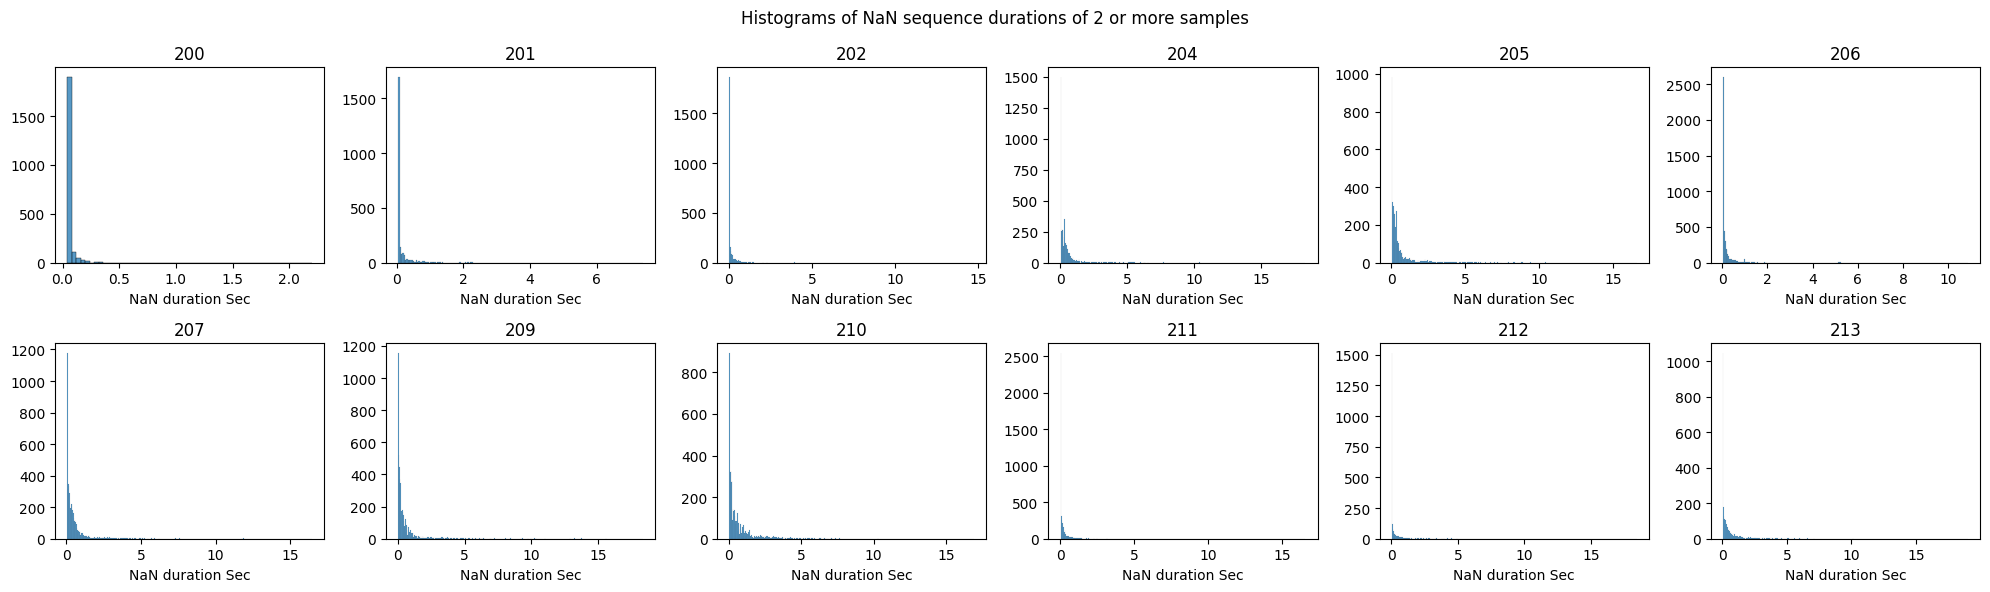

In [60]:
data_dir = "./results/new/resampled/"
resampled_marked_nan_list = []
fig, axs = plt.subplots(2,6,figsize=(20,6))
for j,participant_id in enumerate(participant_list):
    data_path = os.path.join(data_dir, str(participant_id) + "_nonan_50_resampled_data.csv")
    data_df = pd.read_csv(data_path)
    data_df['NaN - Count'] = pd.Series()
    nan_sequence_lengths = []
    for i,trial_no in enumerate(sorted(data_df['Trial no'].unique())):
        trial = data_df[data_df['Trial no']==trial_no]
        nan_list = find_consecutive_nans(trial)
        data_df.loc[data_df['Trial no']==trial_no,'NaN - Count'] = mark_nan_sequences(trial)
        nan_sequence_lengths.append(nan_list)

    resampled_marked_nan_list.append(data_df)
    nan_lengths = pd.concat(nan_sequence_lengths)
    nan_sequence_df = pd.DataFrame()
    nan_sequence_df['NaN duration Sec'] = nan_lengths*0.02
    sns.histplot(nan_sequence_df,x='NaN duration Sec',binwidth=0.04,ax=axs[j//6,j%6])
    axs[j//6,j%6].set_title(str(participant_id))
    if j!=0 or j!=6:
        axs[j//6,j%6].set_ylabel('')
fig.suptitle('Histograms of NaN sequence durations of 2 or more samples')
plt.tight_layout()
plt.show()

Even when omitting 1 sample NaN points, in general the NaN sequence lengths are concentrated in the 2 sample bin, so 0.04 s duration. Further on I'll plot histograms for each block for each participant.

In [ ]:
blocks = np.arange(11)
fig, axs = plt.subplots(2,6,figsize=(20,6))
for j,participant_id in enumerate(participant_list):
    data_path = os.path.join(data_dir, str(participant_id) + "_nonan_50_resampled_data.csv")
    data_df = pd.read_csv(data_path)
    data_df['NaN - Count'] = pd.Series()
    nan_sequence_lengths = []
    for i,trial_no in enumerate(sorted(data_df['Trial no'].unique())):
        trial = data_df[data_df['Trial no']==trial_no]
        nan_list = find_consecutive_nans(trial)
        data_df.loc[data_df['Trial no']==trial_no,'NaN - Count'] = mark_nan_sequences(trial)
        nan_sequence_lengths.append(nan_list)

    resampled_marked_nan_list.append(data_df)
    nan_lengths = pd.concat(nan_sequence_lengths)
    nan_sequence_df = pd.DataFrame()
    nan_sequence_df['NaN duration Sec'] = nan_lengths*0.02
    sns.histplot(nan_sequence_df,x='NaN duration Sec',binwidth=0.04,ax=axs[j//6,j%6])
    axs[j//6,j%6].set_title(str(participant_id))
    if j!=0 or j!=6:
        axs[j//6,j%6].set_ylabel('')
fig.suptitle('Histograms of NaN sequence durations of 2 or more samples')
plt.tight_layout()
plt.show()